In [2]:
import os
import pandas as pd
from openai import OpenAI
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
from datasets import Dataset
import os
import pandas as pd
from whoosh.index import create_in, open_dir, LockError  # Import LockError
from whoosh.fields import Schema, TEXT
from whoosh.qparser import QueryParser
import openai
import time  # Import the time module
import shutil
import sacrebleu
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

path = "G:\\My Drive\\Work\\Working Papers\\LLM and Legal Advice"

# Set the project root directory
PROJECT_ROOT = Path(path)

# Function to construct paths relative to the project root
def project_path(*args):
    return PROJECT_ROOT.joinpath(*args)


# OpenAI API setup

# Construct the path to the text file
text_file_path = project_path("scripts", "openai_project_api_key.txt")

# Open and read the text file, saving the content as a string
with open(text_file_path, 'r') as file:
    file_text = file.read()  # Read the entire content into a string

client = OpenAI(
  api_key=file_text,
)

In [3]:
df = pd.read_csv(project_path("data","housing_CA_posts.csv"))
# df['post'] = 'Title: ' + df['ques_title'] + ' \n Body: ' + df['ques_text']

In [953]:
# df.to_csv(project_path("data","housing_CA_posts.csv"))

In [633]:
# model_choice = "gpt-4o-mini"

# def concatenate_strings(*args):
#     return '; '.join(str(arg) for arg in args if isinstance(arg, str))
    
# def reduce_post(post,var_list):
#     var_list = concatenate_strings(var_list)
#     response = client.chat.completions.create(
#         model=model_choice,
#         messages=[
#             {
#                 "role": "system",
#                 "content": f"""
#                     You are a helpful assistant analyzing Reddit r/legaladvice posts. You will be given a post and asked to transform it in different ways. Don't return anything else but the transformed post. Don't change any words besides what you are specifically instructed to. Please remove ALL information that: {var_list}. Do not keep any information of this kind.
#                 """
#             },
#             {
#                 "role": "user",
#                 "content": f"{post}"

#             }
#         ],
#         temperature=0,
#         max_tokens=1024,
#         top_p=1,
#         frequency_penalty=0,
#         presence_penalty=0
#     )
    
#     return response.choices[0].message.content


# def rewrite_post(post):
#     response = client.chat.completions.create(
#         model=model_choice,
#         messages=[
#             {
#                 "role": "system",
#                 "content": r"""
#                     You are a helpful assistant analyzing Reddit r/legaladvice posts. Don't return anything else but the transformed post. Keep the style of a reddit post, and the original writer. Don't genera
#                 """
#             },
#             {
#                 "role": "user",
#                 "content": f"Please rewrite the post to make it much less clear what the legal question or conflict is. You can add irrelevant informaton if needed. Post: '{post}'"
#             }
#         ],
#         temperature=0,
#         max_tokens=256,
#         top_p=1,
#         frequency_penalty=0,
#         presence_penalty=0
#     )
    
#     return response.choices[0].message.content

In [209]:
var_dict = {
    "jurisdiction": "may inform about the jurisdiction, such as the state or city",
    "dates": "is about specific dates, years, or periods of time",
    "money": "is about sums of money",
    "laws": "is about specific laws or regulations, including their names, references, or language",
    "contract": "is about specific lease and contract language",
    "documentation": "is related to documentation of communications, such as keeping emails, texts, recording phone calls, including the existence of documentation",
    "numbers": "contains numbers or measures, such as sizes, distances or heights (excluding dates or money)"
}

def reduce_post(row):
    post = row['post']  # Get the 'post' from the row
    
    # Create a dictionary to store the columns for the DataFrame
    result_dict = {}
    
    for var, description in var_dict.items():
        # Make the model call with the current post and var
        response = client.chat.completions.create(
            model=model_choice,
            messages=[
                {
                    "role": "system",
                    "content": f"""
                        "You are a helpful assistant analyzing and transforming Reddit r/legaladvice posts."
                        "Don't return anything else but the transformed post."
                        "Please remove ALL {var} related information, that is info that {description}."
                        "Do not keep any information of this kind".
                        "Do not remove any other information besides what you are specifically instructed to."
                    """
                },
                {
                    "role": "user",
                    "content": f"{post}"
                }
            ],
            temperature=0,
            max_tokens=1024,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )
        
        # Extract the content of the response
        transformed_post = response.choices[0].message.content
        
        # Add the transformed post to the result dictionary with the var name
        result_dict[f'transformed_post_{var}'] = transformed_post
        
    return pd.Series(result_dict)

def apply_reduce_post(df):

    # Apply the transform_row function to each row of the original DataFrame
    transformed_data = df.apply(reduce_post, axis=1)
    
    # Concatenate the original DataFrame with the transformed data
    result_df = pd.concat([df, transformed_data], axis=1)
    
    return result_df

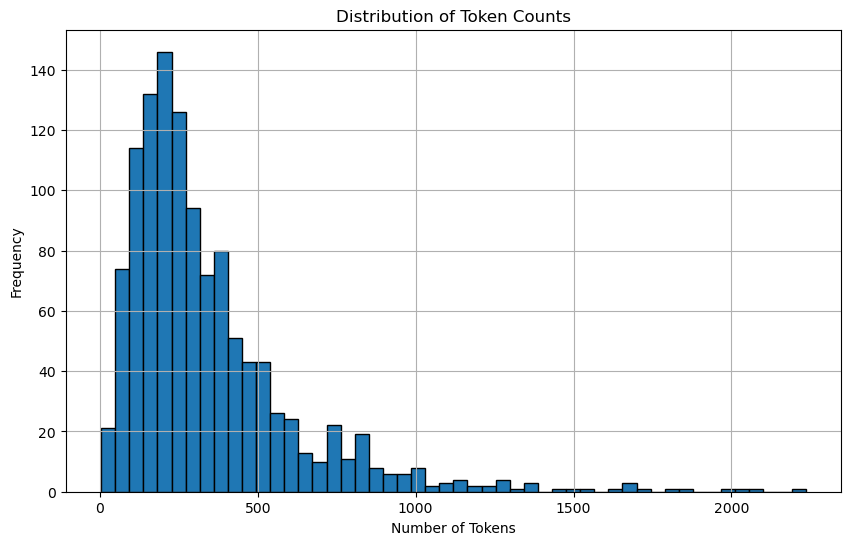

count    1184.000000
mean      346.322635
std       284.357957
min         4.000000
25%       165.750000
50%       264.000000
75%       431.250000
max      2235.000000
Name: num_tokens, dtype: float64


In [139]:
# Load spacy's model for tokenization (e.g., en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

# Calculate number of tokens for each row using spacy
df['num_tokens'] = df['post'].apply(lambda x: len(nlp(x)))

# Plot the distribution of token counts
plt.figure(figsize=(10, 6))
plt.hist(df['num_tokens'], bins=50, edgecolor='black')
plt.title('Distribution of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display the token count distribution summary
print(df['num_tokens'].describe())

In [117]:
# Load the English model
nlp = spacy.load("en_core_web_sm")

def highlight_missing_spacy(text1, text2):
    # Process both texts with spaCy
    doc1 = nlp(text1)
    doc2 = nlp(text2)
    
    # Get the set of tokens (words) in both texts
    tokens1 = set([token.text for token in doc1 if not token.is_punct and not token.is_stop])
    tokens2 = set([token.text for token in doc2 if not token.is_punct and not token.is_stop])
    
    # Find missing tokens in text2
    missing_tokens = tokens1 - tokens2
    
    return missing_tokens

for col in example_reduced.columns:
    text1 = example_reduced.loc[0,'post']
    text2 = example_reduced.loc[0, col]
    missing_tokens = highlight_missing_spacy(text1,text2)
    print(f"Missing tokens from variable: {col}", missing_tokens)


Missing tokens from variable: post set()
Missing tokens from variable: transformed_post_jurisdiction {'older', 't', '9.1', ' ', 'renewals', 'condo', 'san', 'california', 'years', 'single', 'jan', 'California', '2022', 'home', 'LLC', 'diego', 'owned', 'family', 'Details', 'reflect', 'found', 'controlled', 'AB1482', 's', 'ends', '15', 'market', 'aug', 'didn'}
Missing tokens from variable: transformed_post_dates {'2019', '2022', 'ends', 's', 'effect', ' ', 'california', 'form', 't', 'went', '2018', 'san', 'didn', 'diego', 'aug', 'renewals', 'jan'}
Missing tokens from variable: transformed_post_money {'4.1K.', 't', '9.1', ' ', '4.1', 'san', 'california', 'jan', '$', '1', '32', 'diego', 'K', 's', '3.6', 'aug', 'didn', '3.1', '24'}
Missing tokens from variable: transformed_post_laws {'2019', 'AB1482', 's', 'effect', ' ', 'california', 'form', '9.1', 'went', 'cap', 't', 'didn', 'diego', 'aug', 'san', 'written', 'laws', 'jan'}
Missing tokens from variable: transformed_post_contract {'4.1K.', '

In [134]:
from sklearn.preprocessing import StandardScaler

def calculate_clarity_for_text_columns(new_df, text_columns):
    for text_col in text_columns:
        print(f"Processing column: {text_col}")
        
        # Apply the clarity scoring function to the text column
        clarity_metrics = new_df[text_col].apply(score_text_clarity).apply(pd.Series)
        
        # Check if the clarity metrics have non-zero, meaningful values
        print(f"Clarity metrics for {text_col}:")
        print(clarity_metrics.head())
        
        # Handle NaN or zero values if present (fill NaNs with 0)
        clarity_metrics.fillna(0, inplace=True)
        
        # Initialize a new scaler (StandardScaler)
        scaler = StandardScaler()
        scaled_metrics = scaler.fit_transform(clarity_metrics)
        
        # Check the scaled metrics for debugging
        print(f"Scaled metrics for {text_col}:")
        print(scaled_metrics[:5])
        
        # Sum the scaled metrics to calculate the clarity score
        new_df[f'{text_col}_clarity_score'] = np.sum(scaled_metrics, axis=1)
    
    return new_df

def plot_clarity_scores(df, text_columns):
    plt.figure(figsize=(10, 6))

    # Plot each clarity score
    for col in text_columns:
        clarity_col = f'{col}_clarity_score'
        if clarity_col in df.columns:
            plt.plot(df.index, df[clarity_col], label=f'{col} Clarity Score', marker='o')
        else:
            print(f"Column {clarity_col} not found in DataFrame.")

    # Add labels, title, and legend
    plt.xlabel('Index')
    plt.ylabel('Clarity Score')
    plt.title('Clarity Scores for Text Columns')
    plt.legend()

    # Display the plot
    plt.show()

text_columns = ['post', 'transformed_post1', 'transformed_post2', 'transformed_post3', 'transformed_post4','transformed_post5','transformed_post6','transformed_post7']
example_reduced = calculate_clarity_for_text_columns(example_reduced, text_columns)
plot_clarity_scores(example_reduced, text_columns)

# use court cases

In [311]:
# df_cases = pd.read_csv(project_path("data","law_opinion_search_results.csv"))

In [315]:
# df_cases = df_cases[df_cases['excerpt'].notna()].reset_index(drop=True)
# df_cases = df_cases.drop('Bloomberg Law Search URL: https://www.bloomberglaw.com/search/results/adf7121ce6310b754e92eb8bb35675d2', axis=1)

In [1126]:
df_cases = pd.read_csv(project_path("data", "RA", "law_opinion_search_results_yuval.csv"), encoding='latin1')

In [1122]:
df_cases = df_cases.dropna(subset=['verdict'])
df_cases = df_cases.loc[df_cases['verdict'] == 'v']

In [16]:
pd.set_option('display.max_colwidth', None)

df_cases.columns

Index(['Bloomberg Law Search URL', 'year', 'citation', 'excerpt', 'verdict',
       'comment'],
      dtype='object')

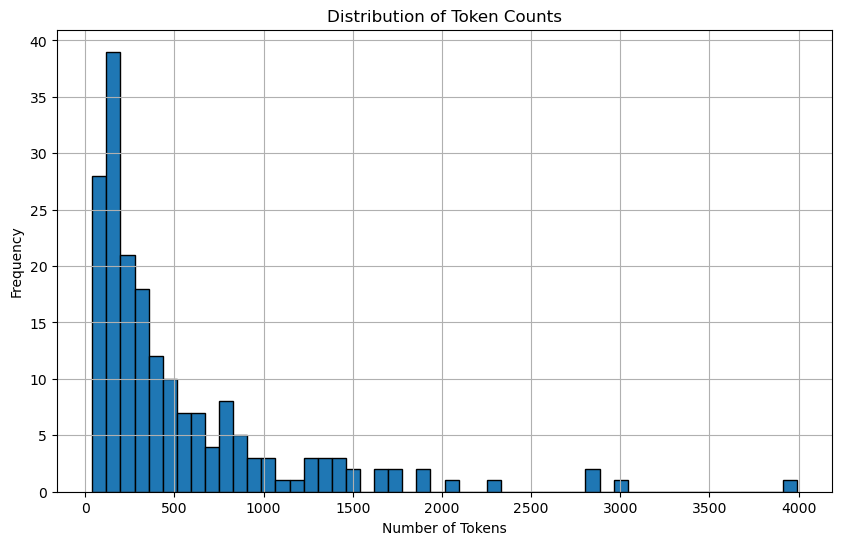

count     190.000000
mean      533.363158
std       602.584680
min        39.000000
25%       149.250000
50%       303.500000
75%       689.000000
max      3990.000000
Name: num_tokens, dtype: float64


In [20]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt

# Load spacy's model for tokenization (e.g., en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

# Calculate number of tokens for each row using spacy
df_cases['num_tokens'] = df_cases['excerpt'].apply(lambda x: len(nlp(x)))

# Plot the distribution of token counts
plt.figure(figsize=(10, 6))
plt.hist(df_cases['num_tokens'], bins=50, edgecolor='black')
plt.title('Distribution of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display the token count distribution summary
print(df_cases['num_tokens'].describe())

# keep only excerpts that are not too long
df_cases = df_cases.loc[df_cases['num_tokens'] < 512]

In [26]:
model_choice = "gpt-4o-mini"

def rewrite_case(excerpt):
    response = client.chat.completions.create(
        model=model_choice,
        messages=[
            {
                "role": "system",
                "content": r"""
                    You are a helpful assistant. You are given an excerpt from a court case. rewrite it as if it was a Reddit r/legal_advice post. Use a first person perspective and the appropriate style of r/legal_advice. Don't return anything else but the transformed text. Generate a title and body.
                """
            },
            {
                "role": "user",
                "content": f"Excerpt: '{excerpt}'"
            }
        ],
        temperature=0,
        max_tokens=512,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    
    return response.choices[0].message.content

In [28]:
df_cases['excerpt_rewrite'] = df_cases.apply(lambda row: rewrite_case(row['excerpt']), axis=1)

C:\Users\mitha\AppData\Local\Temp\ipykernel_23356\4143201029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cases['excerpt_rewrite'] = df_cases.apply(lambda row: rewrite_case(row['excerpt']), axis=1)


In [32]:
df_cases.to_csv(project_path("data", "df_cases_rewrite.csv"), index=False)

In [369]:
# import spacy
# from sklearn.metrics.pairwise import cosine_similarity

# # Load the spaCy model with vectors
# nlp = spacy.load("en_core_web_md")

# # Function to convert a single text to its spaCy vector representation
# def get_spacy_embedding(text):
#     return nlp(text).vector

# # New function to calculate cosine similarity between two input texts A and B
# def calculate_cosine_similarity(text_A, text_B):
#     embedding_A = get_spacy_embedding(text_A)
#     embedding_B = get_spacy_embedding(text_B)
#     return cosine_similarity([embedding_A], [embedding_B])[0][0]

In [407]:
# # similarity_score = calculate_cosine_similarity(case_example, case_example_rewrite)
# df_cases['similarity_score'] = df_cases.apply(lambda row: calculate_cosine_similarity(row['excerpt'],row['excerpt_rewrite']), axis=1)

# calculate clarity

In [1138]:
import spacy
import textstat
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MinMaxScaler

# Load spaCy's language model
nlp = spacy.load('en_core_web_sm')

# Function to calculate syntactic complexity
def syntactic_complexity(text):
    doc = nlp(text)
    num_sentences = len(list(doc.sents))
    num_words = len(doc)
    num_complex_words = sum(1 for token in doc if len(token.text) > 6)  # Example of complex word definition
    
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0
    return num_sentences, num_words, num_complex_words, avg_sentence_length

# Function to calculate lexical cohesion using spaCy's built-in similarity between sentences
def lexical_cohesion(text):
    doc = nlp(text)
    sentences = list(doc.sents)
    
    if len(sentences) > 1:
        similarities = [sent1.similarity(sent2) for sent1, sent2 in zip(sentences, sentences[1:])]
        avg_similarity = sum(similarities) / len(similarities) if similarities else 0
    else:
        avg_similarity = 0
    
    return avg_similarity

# Function to calculate readability metrics
def readability_metrics(text):
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    smog_index = textstat.smog_index(text)
    flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
    
    return flesch_reading_ease, gunning_fog, smog_index, flesch_kincaid_grade

# Function to add separate clarity score columns to the DataFrame
def score_text_clarity(text):
    # Get syntactic complexity scores
    num_sentences, num_words, num_complex_words, avg_sentence_length = syntactic_complexity(text)
    
    # Get lexical cohesion score
    avg_similarity = lexical_cohesion(text)
    
    # Get readability metrics
    flesch_reading_ease, gunning_fog, smog_index, flesch_kincaid_grade = readability_metrics(text)
    
    return (num_sentences, num_words, num_complex_words, avg_sentence_length,
            avg_similarity, flesch_reading_ease, gunning_fog, smog_index, flesch_kincaid_grade)


# Load the spaCy model with vectors
nlp = spacy.load("en_core_web_md")

# Function to convert a single text to its spaCy vector representation
def get_spacy_embedding(text):
    return nlp(text).vector

In [1140]:
# Apply the clarity scoring function and expand the resulting tuples into new columns
df[['num_sentences', 'num_words', 'num_complex_words', 'avg_sentence_length',
    'avg_similarity', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'flesch_kincaid_grade']] = df['post'].apply(score_text_clarity).apply(pd.Series)

# Standardize (Min-Max Scaling) the scores to bring all values to a 0-1 range
scaler = MinMaxScaler()

# Apply Min-Max scaling to each of the metrics
scaled_values = scaler.fit_transform(df[['num_sentences', 'num_words', 'num_complex_words', 'avg_sentence_length',
                                         'avg_similarity', 'flesch_reading_ease', 'gunning_fog', 
                                         'smog_index', 'flesch_kincaid_grade']])

# Create clarity_score from the sum of scaled variables
clarity_score = scaled_values.sum(axis=1)

# Add clarity_score back to the original DataFrame
df['clarity_score'] = clarity_score

C:\Users\mitha\AppData\Local\Temp\ipykernel_23356\1640216251.py:25: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities = [sent1.similarity(sent2) for sent1, sent2 in zip(sentences, sentences[1:])]


In [1160]:
df_cases_rewrite = pd.read_csv(project_path("data", "df_cases_rewrite.csv"), encoding='latin1')

In [1184]:
df_cases_rewrite.columns

Index(['Bloomberg Law Search URL', 'year', 'citation', 'excerpt', 'verdict',
       'comment', 'num_tokens', 'excerpt_rewrite', 'num_sentences',
       'num_words', 'num_complex_words', 'avg_sentence_length',
       'avg_similarity', 'flesch_reading_ease', 'gunning_fog', 'smog_index',
       'flesch_kincaid_grade', 'clarity_score', 'group'],
      dtype='object')

In [1186]:
# apply clarity score to the rewritten cases
var = 'excerpt_rewrite'
# var = 'excerpt'

# Apply the clarity scoring function and expand the resulting tuples into new columns
df_cases_rewrite[['num_sentences', 'num_words', 'num_complex_words', 'avg_sentence_length',
    'avg_similarity', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'flesch_kincaid_grade']] = df_cases_rewrite[f'{var}'].apply(score_text_clarity).apply(pd.Series)

# Standardize (Min-Max Scaling) the scores to bring all values to a 0-1 range
scaler = MinMaxScaler()

# Apply Min-Max scaling to each of the metrics
scaled_values = scaler.fit_transform(df_cases_rewrite[['num_sentences', 'num_words', 'num_complex_words', 'avg_sentence_length',
                                         'avg_similarity', 'flesch_reading_ease', 'gunning_fog', 
                                         'smog_index', 'flesch_kincaid_grade']])

# Create clarity_score from the sum of scaled variables
clarity_score = scaled_values.sum(axis=1)

# Add clarity_score back to the original DataFrame
df_cases_rewrite[f'{var}_clarity_score'] = clarity_score

C:\Users\mitha\AppData\Local\Temp\ipykernel_23356\1640216251.py:25: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities = [sent1.similarity(sent2) for sent1, sent2 in zip(sentences, sentences[1:])]


In [1198]:
df_cases_rewrite.columns

Index(['Bloomberg Law Search URL', 'year', 'citation', 'excerpt', 'verdict',
       'comment', 'num_tokens', 'excerpt_rewrite', 'num_sentences',
       'num_words', 'num_complex_words', 'avg_sentence_length',
       'avg_similarity', 'flesch_reading_ease', 'gunning_fog', 'smog_index',
       'flesch_kincaid_grade', 'excerpt_rewrite_clarity_score', 'group',
       'excerpt_clarity_score'],
      dtype='object')

In [1200]:
df_cases_rewrite.rename(columns = {'excerpt_rewrite_clarity_score':'clarity_score'}, inplace = True)

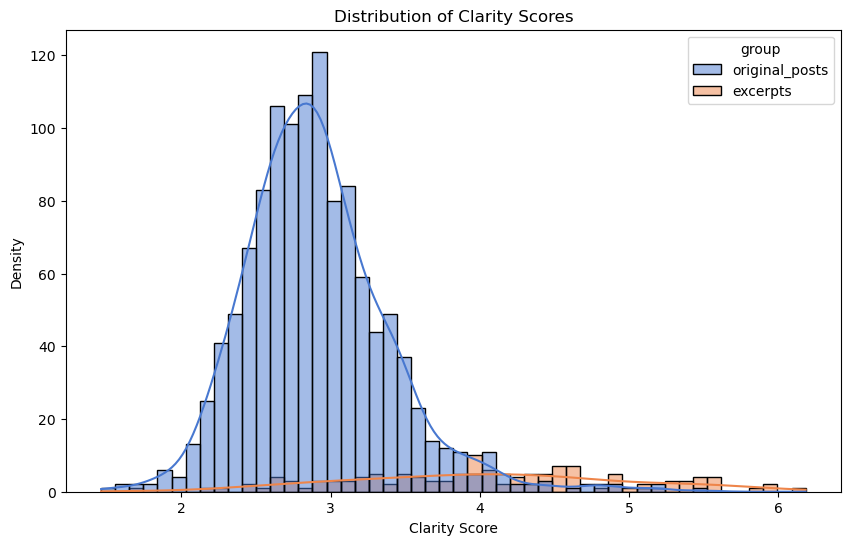

In [1204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df1 and df2 are your two DataFrames, and 'variable' is the column name you want to plot
df1 = df
df2 = df_cases_rewrite

# Add a column to indicate the group
df1['group'] = 'original_posts'
df2['group'] = 'rewritten_excerpts'

# Concatenate the two DataFrames
df_combined = pd.concat([df1[['clarity_score', 'group']], df2[['clarity_score', 'group']]])

# Plotting the distributions
plt.figure(figsize=(10, 6))
sns.histplot(df_combined, x='clarity_score', hue='group', kde=True, palette='muted', bins=50)

plt.title('Distribution of Clarity Scores')
plt.xlabel('Clarity Score')
plt.ylabel('Density')
plt.legend(labels=['rewritten_excerpts','original_posts'])
plt.savefig(project_path("figures", f"clarity_scores_dist_original_vs_excerpts.png"), bbox_inches='tight')

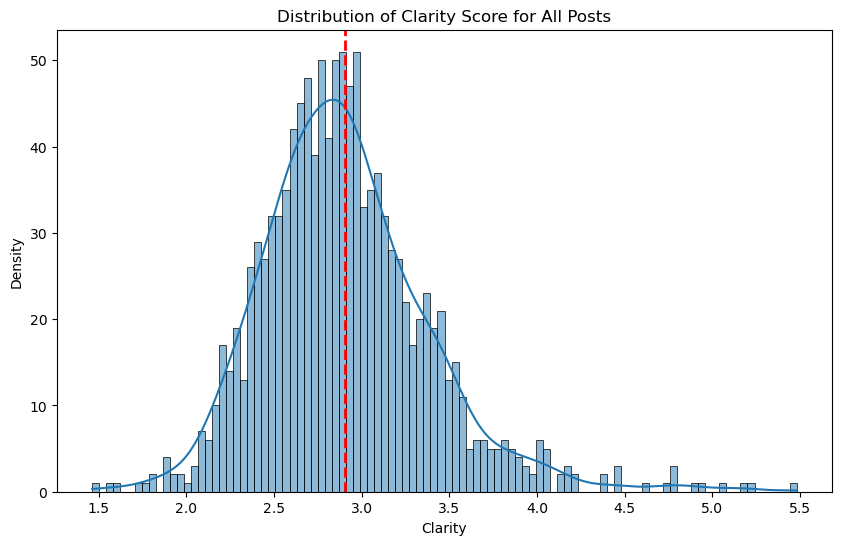

In [1154]:
# plot the distribution of clarity scores

overall_mean = df['clarity_score'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(df['clarity_score'], kde=True, bins=100)
plt.axvline(overall_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {overall_mean:.2f}')
plt.title(f'Distribution of Clarity Score for All Posts')
plt.xlabel('Clarity')
plt.ylabel('Density')
plt.savefig(project_path("figures", f"clarity_scores_posts.png"), bbox_inches='tight')

# generate answers

In [122]:
import re

model_choice = "gpt-4o-mini"

SYSTEM_INSTRUCTION = r"""
You are a helpful legal assistant. You are given a text from a person seeking legal help. Please answer the following questions. Provide your answers strictly in the format below, without adding any extra text or explanations.

1. **<Q1>** Does the text have a legal problem that a lawyer may be able to aid with? Answer only Yes or No.

2. **<Q2>** Does the text contain all necessary information for a lawyer to answer it? Answer only Yes or No.

3. **<Q3>** How usable is the text for a legal professional? Rate from 1 to 7, where 1 means "not usable at all due to lack of information or clarity" and 7 means "very usable with comprehensive information."

4. **<Q4>** How specific is the text? Rate from 1 (not specific at all) to 7 (very specific).

5. **<Q5>** How legalistic is the text? Rate from 1 (uses everyday language) to 7 (uses precise legal terminology).

6. **<Q6>** How factually robust is the text? Rate from 1 (lacking facts) to 7 (very factually detailed).

7. **<Q7>** Name any factors that are missing from the text that would be useful for a lawyer reviewing the case. List any missing factors separated by '@@@'. If there are none, leave this section blank.

8. **<Q8>** Provide your best response to the questions posed in the text.

**Return the answers in the following format:**

**LEGAL_PROB**
<Q1 answer>
**LEGAL_INFO**
<Q2 answer>
**USE_RANK**
<Q3 answer>
**SPEC_RANK**
<Q4 answer>
**LEG_RANK**
<Q5 answer>
**FACT_RANK**
<Q6 answer>
**VAR_MISSING**
<Q7 answer1 @@@ answer2 @@@ answer3>
**BEST_RESPONSE**
<Q8 answer>

                """
def classify_post(post):
    response = client.chat.completions.create(
        model=model_choice,
        messages=[
            {
                "role": "system",
                "content": SYSTEM_INSTRUCTION
            },
            {
                "role": "user",
                "content": f"Query: '{post}'"
            }
        ],
        temperature=0,
        max_tokens=1012,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    
    return response.choices[0].message.content

def parse_assistant_output(output):
    """
    Parses the assistant's output and extracts answers to each question.
    """
    if output is None:
        return None  # Handle cases where the output is None due to an API error
    
    # Define the headers as they appear in the output
    headers = [
        'LEGAL_PROB',
        'LEGAL_INFO',
        'USE_RANK',
        'SPEC_RANK',
        'LEG_RANK',
        'FACT_RANK',
        'VAR_MISSING',
        'BEST_RESPONSE'
    ]
    
    # Initialize a dictionary to hold the parsed data
    data = {header: None for header in headers}
    
    # Updated regex pattern to be more flexible with whitespace
    pattern = r'\*\*(.*?)\*\*\s*([\s\S]*?)(?=(\*\*|$))'
    
    # Find all matches in the output
    matches = re.findall(pattern, output)
    
    # Populate the dictionary with the extracted content
    for match in matches:
        header = match[0].strip()
        content = match[1].strip()
        if header in data:
            data[header] = content
    return data

def process_text_entry(text):
    """
    Processes a single text entry by generating the assistant's output and parsing it.
    Returns a dictionary with the parsed answers.
    """
    assistant_output = classify_post(text)
    parsed_data = parse_assistant_output(assistant_output)
    return parsed_data


def process_column(df, column_name):
    # Apply the pipeline to a specific text column
    df_results = df[column_name].apply(lambda x: process_text_entry(x))
    df_parsed = pd.DataFrame(df_results.tolist())
    
    # Rename columns to indicate which original text column they come from
    renamed_columns = {col: f"{col}_{column_name}" for col in df_parsed.columns}
    df_parsed.rename(columns=renamed_columns, inplace=True)
    
    return df_parsed
    

def clean_data(df):
    """
    Cleans and formats the DataFrame after processing multiple text columns.
    It dynamically handles column names that are prefixed with the original column name.
    """
    # Get all columns in the DataFrame
    all_columns = df.columns
    
    # Ranking columns to clean (we'll look for prefixed versions of these)
    base_ranking_cols = ['USE_RANK', 'SPEC_RANK', 'LEG_RANK', 'FACT_RANK']
    
    # Yes/No columns
    base_yes_no_cols = ['LEGAL_PROB', 'LEGAL_INFO']
    
    # Loop through and clean ranking columns
    for base_col in base_ranking_cols:
        # Find all columns that match the base column (e.g., USE_RANK_text_col1)
        matching_cols = [col for col in all_columns if base_col in col]
        for col in matching_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Loop through and clean Yes/No columns
    for base_col in base_yes_no_cols:
        # Find all columns that match the base column (e.g., LEGAL_PROB_text_col1)
        matching_cols = [col for col in all_columns if base_col in col]
        for col in matching_cols:
            df[col] = df[col].str.strip().str.capitalize()
    
    # Handle VAR_MISSING (split into a list)
    var_missing_cols = [col for col in all_columns if 'VAR_MISSING' in col]
    for col in var_missing_cols:
        df[f'{col}_LIST'] = df[col].apply(lambda x: [item.strip() for item in x.split('@@@')] if pd.notna(x) else [])
    
    return df

def main_oneshot(df, text_columns):
    """
    Processes the entire DataFrame by applying the pipeline to multiple text columns
    and returns the final DataFrame with new columns for each original text column.
    
    Args:
    - df: DataFrame containing the original data.
    - text_columns: List of column names (strings) in df to apply the pipeline on.
    """
    for column_name in text_columns:
        # Process each text column and append the results to the original DataFrame
        df_results = process_column(df, column_name)
        
        # Ensure the index of df_results matches the original DataFrame
        df_results.index = df.index
        
        # Concatenate the results with the original DataFrame
        df = pd.concat([df, df_results], axis=1)
    
    # Clean and format the entire DataFrame
    df_cleaned = clean_data(df)
    
    return df_cleaned

# compare posts and court cases

In [52]:
df_posts = df[['post']].copy()
df_posts['type'] = 'post'  # Add a 'type' column to identify the source
df_posts = df_posts.rename(columns={'post': 'text'})

df_cases_excerpt = df_cases[['excerpt']].copy()
df_cases_excerpt['type'] = 'excerpt'  # Add a 'type' column to identify the source
df_cases_excerpt = df_cases_excerpt.rename(columns={'excerpt': 'text'})

df_cases_excerpt_rewrite = df_cases[['excerpt_rewrite']].copy()
df_cases_excerpt_rewrite['type'] = 'excerpt_rewrite'  # Add a 'type' column to identify the source
df_cases_excerpt_rewrite = df_cases_excerpt_rewrite.rename(columns={'excerpt_rewrite': 'text'})

# Concatenate the two DataFrames
new_df = pd.concat([df_posts, df_cases_excerpt,df_cases_excerpt_rewrite], ignore_index=True)

# Apply the embedding function to the 'text' column in new_df
new_df['embedding'] = new_df['text'].apply(get_spacy_embedding)

In [79]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def produce_plot(method, df):
    embeddings = np.vstack(df['embedding'].values)

    if method == 'pca':
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
    else:
        tsne = TSNE(n_components=2, random_state=42)
        reduced_embeddings = tsne.fit_transform(embeddings)

    # Add jitter to the reduced embeddings to make points more jittery
    jitter_strength = 0.05  # Adjust this to control jitter amount
    jitter = np.random.normal(0, jitter_strength, reduced_embeddings.shape)
    reduced_embeddings_jittered = reduced_embeddings + jitter
    
    # Plot the 2D visualization
    plt.figure(figsize=(10, 7))
    
    # Get unique labels from the 'type' column and assign a color to each type
    labels = new_df['type'].unique()
    colors = ['r', 'g', 'b', 'y']  # Add more colors if necessary
    
    # Plot each group of embeddings with a different color based on 'type'
    for i, label in enumerate(labels):
        mask = new_df['type'] == label
        plt.scatter(reduced_embeddings_jittered[mask, 0], reduced_embeddings_jittered[mask, 1], 
                    c=colors[i], label=label, alpha=0.7, s=50)  # You can adjust 's' for point size and 'alpha' for transparency
    
    # Add axis labels and title
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{method} 2D Visualization')
    plt.legend()
    plt.savefig(project_path("figures", f"plot_embeddings_{method}.png"), bbox_inches='tight')
    plt.show()

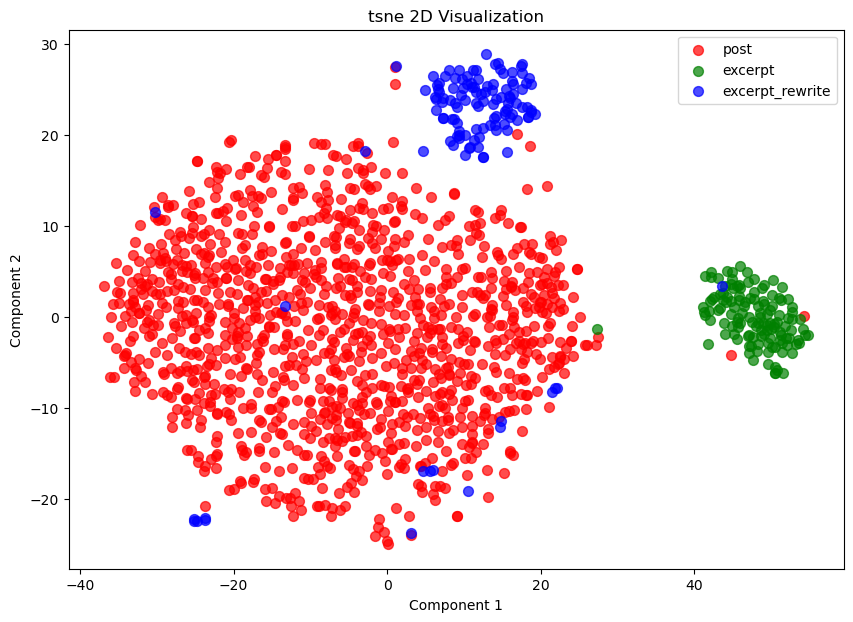

In [81]:
produce_plot('tsne',new_df)

# generate answers with few shot

In [16]:
import re

model_choice = "gpt-4o-mini"

SYSTEM_INSTRUCTION = r"""
You are a helpful legal assistant. You are given a text from a person seeking legal help. Please answer the following questions. Provide your answers strictly in the format below, without adding any extra text or explanations.

1. **<Q1>** Does the text have a legal problem that a lawyer may be able to aid with? Answer only Yes or No.

2. **<Q2>** Does the text contain all necessary information for a lawyer to answer it? Answer only Yes or No.

3. **<Q3>** How usable is the text for a legal professional? Rate from 1 to 7, where 1 means "not usable at all due to lack of information or clarity" and 7 means "very usable with comprehensive information."

4. **<Q4>** How specific is the text? Rate from 1 (not specific at all) to 7 (very specific).

5. **<Q5>** How legalistic is the text? Rate from 1 (uses everyday language) to 7 (uses precise legal terminology).

6. **<Q6>** How factually robust is the text? Rate from 1 (lacking facts) to 7 (very factually detailed).

7. **<Q7>** Name any factors that are missing from the text that would be useful for a lawyer reviewing the case. List any missing factors separated by '@@@'. If there are none, leave this section blank.

8. **<Q8>** Provide your best response to the questions posed in the text.

**Return the answers in the following format:**

**LEGAL_PROB**
<Q1 answer>
**LEGAL_INFO**
<Q2 answer>
**USE_RANK**
<Q3 answer>
**SPEC_RANK**
<Q4 answer>
**LEG_RANK**
<Q5 answer>
**FACT_RANK**
<Q6 answer>
**VAR_MISSING**
<Q7 answer1 @@@ answer2 @@@ answer3>
**BEST_RESPONSE**
<Q8 answer>

                """
def classify_post_fewshot(post):
    response = client.chat.completions.create(
        model=model_choice,
        messages=[
            {
                "role": "system",
                "content": SYSTEM_INSTRUCTION
            },
            {
                "role": "user",
                "content": f"This is an example of a very high quality query, which would rank very high: {excerpt_rewrite}. Now please answer about this query: {post}"
            }
        ],
        temperature=0,
        max_tokens=1012,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    
    return response.choices[0].message.content

def parse_assistant_output(output):
    """
    Parses the assistant's output and extracts answers to each question.
    """
    if output is None:
        return None  # Handle cases where the output is None due to an API error
    
    # Define the headers as they appear in the output
    headers = [
        'LEGAL_PROB',
        'LEGAL_INFO',
        'USE_RANK',
        'SPEC_RANK',
        'LEG_RANK',
        'FACT_RANK',
        'VAR_MISSING',
        'BEST_RESPONSE'
    ]
    
    # Initialize a dictionary to hold the parsed data
    data = {header: None for header in headers}
    
    # Updated regex pattern to be more flexible with whitespace
    pattern = r'\*\*(.*?)\*\*\s*([\s\S]*?)(?=(\*\*|$))'
    
    # Find all matches in the output
    matches = re.findall(pattern, output)
    
    # Populate the dictionary with the extracted content
    for match in matches:
        header = match[0].strip()
        content = match[1].strip()
        if header in data:
            data[header] = content
    return data

def process_text_entry_fewshot(text):
    """
    Processes a single text entry by generating the assistant's output and parsing it.
    Returns a dictionary with the parsed answers.
    """
    assistant_output = classify_post_fewshot(text)
    parsed_data = parse_assistant_output(assistant_output)
    return parsed_data


def process_column_fewshot(df, column_name):
    # Apply the pipeline to a specific text column
    df_results = df[column_name].apply(lambda x: process_text_entry_fewshot(x))
    df_parsed = pd.DataFrame(df_results.tolist())
    
    # Rename columns to indicate which original text column they come from
    renamed_columns = {col: f"{col}_{column_name}" for col in df_parsed.columns}
    df_parsed.rename(columns=renamed_columns, inplace=True)
    
    return df_parsed
    

def clean_data(df):
    """
    Cleans and formats the DataFrame after processing multiple text columns.
    It dynamically handles column names that are prefixed with the original column name.
    """
    # Get all columns in the DataFrame
    all_columns = df.columns
    
    # Ranking columns to clean (we'll look for prefixed versions of these)
    base_ranking_cols = ['USE_RANK', 'SPEC_RANK', 'LEG_RANK', 'FACT_RANK']
    
    # Yes/No columns
    base_yes_no_cols = ['LEGAL_PROB', 'LEGAL_INFO']
    
    # Loop through and clean ranking columns
    for base_col in base_ranking_cols:
        # Find all columns that match the base column (e.g., USE_RANK_text_col1)
        matching_cols = [col for col in all_columns if base_col in col]
        for col in matching_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Loop through and clean Yes/No columns
    for base_col in base_yes_no_cols:
        # Find all columns that match the base column (e.g., LEGAL_PROB_text_col1)
        matching_cols = [col for col in all_columns if base_col in col]
        for col in matching_cols:
            df[col] = df[col].str.strip().str.capitalize()
    
    # Handle VAR_MISSING (split into a list)
    var_missing_cols = [col for col in all_columns if 'VAR_MISSING' in col]
    for col in var_missing_cols:
        df[f'{col}_LIST'] = df[col].apply(lambda x: [item.strip() for item in x.split('@@@')] if pd.notna(x) else [])
    
    return df

def main_few_shot(df, text_columns, excerpt_rewrite):
    """
    Processes the entire DataFrame by applying the pipeline to multiple text columns
    and returns the final DataFrame with new columns for each original text column.
    
    Args:
    - df: DataFrame containing the original data.
    - text_columns: List of column names (strings) in df to apply the pipeline on.
    """
    for column_name in text_columns:
        # Process each text column and append the results to the original DataFrame
        df_results = process_column_fewshot(df, column_name)
        
        # Ensure the index of df_results matches the original DataFrame
        df_results.index = df.index
        
        # Concatenate the results with the original DataFrame
        df = pd.concat([df, df_results], axis=1)
    
    # Clean and format the entire DataFrame
    df_cleaned = clean_data(df)
    
    return df_cleaned

In [48]:
df_cases = pd.read_csv(project_path("data", "df_cases_rewrite.csv"), encoding='latin1')
df_answers = pd.read_csv(project_path("data", "df_answers_full.csv"), encoding='latin1')

In [32]:
excerpt_rewrite_example = df_cases['excerpt_rewrite'][37]

In [60]:
sample = df_answers[df_answers['__index_level_0__'].isin(df_raters['__index_level_0__'])]
sample = sample[['__index_level_0__','post']]

In [64]:
df_answers_fewshot = main_few_shot(sample,['post'],excerpt_rewrite_example)
df_answers_fewshot.columns = df_answers_fewshot.columns.str.lower()

,__index_level_0__,post,LEGAL_PROB_post,LEGAL_INFO_post,USE_RANK_post,SPEC_RANK_post,LEG_RANK_post,FACT_RANK_post,VAR_MISSING_post,BEST_RESPONSE_post,VAR_MISSING_post_LIST
2,156837,Title: I want to terminate my lease but my co...,Yes,No,5,5,3,5,@@@,You may have options to terminate your lease d...,"[, ]"
5,28889,Title: [California] How do I get a roommate ou...,Yes,No,5,5,4,5,@ lease agreement details @ John's refusal to ...,You should consult with a lawyer who specializ...,[@ lease agreement details @ John's refusal to...
13,55406,Title: Is a notary needed on a legal document?...,Yes,No,5,5,3,4,Details about the lease agreement @@@ Specific...,It is generally advisable to have signatures n...,"[Details about the lease agreement, Specifics ..."
17,98223,Title: [CA] removing tenant after 2 months \n ...,Yes,No,5,6,3,5,Details on the lease agreement or rental arran...,"You are correct that in California, if there i...",[Details on the lease agreement or rental arra...
27,26322,Title: Common Fence Small Claims Suit in Calif...,Yes,No,5,5,3,6,@$$$ Specific details about the summons and co...,"To best defend yourself, gather all relevant d...",[@$$$ Specific details about the summons and c...
...,...,...,...,...,...,...,...,...,...,...,...
1113,87892,Title: [CA] Landlord is being Unreasonable And...,Yes,No,5,5,3,4,Details about the lease agreement terms @@@ Sp...,You should consult with a lawyer who specializ...,"[Details about the lease agreement terms, Spec..."
1127,153903,Title: My identity was stolen to lease an apar...,Yes,No,5,6,3,5,Details on the property manager's policies and...,You may have a case against the property manag...,[Details on the property manager's policies an...
1142,141633,Title: House was rented out to someone who cre...,Yes,No,4,4,3,3,@@@ details on the rental agreement @@@ specif...,You may have legal recourse against the rental...,"[, details on the rental agreement, specific d..."
1169,49138,Title: [LA CA] Someone just broke into our ho...,Yes,No,5,6,5,6,@ landlord's response history @ specific deman...,"As a tenant in Los Angeles, you have the right...",[@ landlord's response history @ specific dema...


In [87]:
columns_to_suffix = ['legal_prob_post', 'legal_info_post',
       'use_rank_post', 'spec_rank_post', 'leg_rank_post', 'fact_rank_post',
       'var_missing_post', 'best_response_post', 'var_missing_post_list']
df_answers_fewshot = df_answers_fewshot.rename(columns={col: col + '_fewshot' for col in columns_to_suffix})
df_answers_fewshot = df_answers_fewshot.drop('post', axis=1)

In [109]:
sample = df_answers[df_answers['__index_level_0__'].isin(df_raters['__index_level_0__'])]
columns_to_suffix = ['legal_prob_post', 'legal_info_post',
       'use_rank_post', 'spec_rank_post', 'leg_rank_post', 'fact_rank_post',
       'var_missing_post', 'best_response_post', 'var_missing_post_list']
sample = sample.rename(columns={col: col + '_oneshot' for col in columns_to_suffix})

In [113]:
df_merged_shots = pd.merge(sample, df_answers_fewshot, on='__index_level_0__', suffixes=('_oneshot', '_fewshot'))

In [119]:
df_merged_shots = map_yes_no_to_binary(df_merged_shots, substring="legal_prob_")
df_merged_shots = map_yes_no_to_binary(df_merged_shots, substring="legal_info_")

C:\Users\mitha\AppData\Local\Temp\ipykernel_37092\559468307.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_map] = df[columns_to_map].replace(mapping)
C:\Users\mitha\AppData\Local\Temp\ipykernel_37092\559468307.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_map] = df[columns_to_map].replace(mapping)


# interactive prompting

In [1094]:
import openai
import json

model_choice = "gpt-4o-mini"

# response = client.chat.completions.create(

# System prompt for the assistant's role
SYSTEM_PROMPT = "You are a helpful assistant tasked with analyzing legal advice requests."

# Function to send a message to the model
def send_message(role_messages):
    response = client.chat.completions.create(
        model=model_choice,  # or "gpt-4o"
        messages=role_messages,
        temperature=0,
        max_tokens=500,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    return response.choices[0].message.content

# Function to check if the assistant's response asks for the correct information
def validate_request_for_info(assistant_response,var_dict,var):
    # Example validation: look for specific legal terms
    if assistant_response.lower().replace('.', '').replace(',', '') in var_dict[var]:
        return True, var_dict[var]  # Return True and the specific factor requested
    return False, None
  
    # for factor in var_dict.values():
    #     if assistant_response.lower().replace('.', '').replace(',', '') in factor:
    #         return True, factor  # Return True and the specific factor requested
    # return False, None


# Function to output the entire conversation
def output_conversation_as_json(conversation_log):
    # Convert conversation_log list to JSON
    return json.dumps(conversation_log, indent=4)

def output_conversation_as_dataframe(conversation_log):
    # Convert conversation_log list to DataFrame
    return pd.DataFrame(conversation_log)

def decision_tree(df,var,row_num):
    post = df[f'transformed_post_{var}'][row_num]
    original_post = df['post'][row_num]
    
    conversation_log = []  # List to store all conversation entries as dictionaries for easy conversion
    
    # Initial system message
    system_message = {"role": "system", "content": SYSTEM_PROMPT}
    conversation_log.append(system_message)
    
    # User's message
    user_message = {"role": "user", "content": f"Does the following question contain sufficient information for a legal professional to answer it? Answer only yes or no. The question: {post}"}
    conversation_log.append(user_message)
    
    # Send the initial question to the assistant
    role_messages = [system_message, user_message]
    initial_response = send_message(role_messages)
    
    # Save assistant's response
    assistant_initial_message = {"role": "assistant", "content": initial_response}
    conversation_log.append(assistant_initial_message)
    
    # Decision: Does the assistant have enough information?
    if "yes" in initial_response.lower():
        # Assistant believes it has enough info, so the final response is stored
        final_user_message = {"role": "user", "content": f"please provide your best response to the question in 100 words: {post}"}
        conversation_log.append(final_user_message)
        final_assistant_response = send_message([system_message, final_user_message])
        
        # Ensure the assistant response is correctly formatted
        final_assistant_message = {"role": "assistant", "content": final_assistant_response}
        conversation_log.append(final_assistant_message)
    else:
        # If the assistant asks for more information, validate the request
        user_message_more = {"role": "user", "content": f"Which other information do you need out of the following {', '.join(var_dict.keys())} or other? name only one, be very specific."}
        conversation_log.append(user_message_more)
        assistant_response = send_message([system_message, user_message_more])
        
        # Save the assistant response
        assistant_more_message = {"role": "assistant", "content": assistant_response}
        conversation_log.append(assistant_more_message)
        
        valid_request, requested_factor = validate_request_for_info(assistant_response,var_dict,var)
        
        if valid_request:
            # If the request is valid, provide the additional info
            additional_info = f"Here is the additional info on {requested_factor}. please provide your best response to the question in 100 words: {original_post}"
            followup_message = {"role": "user", "content": additional_info}
            conversation_log.append(followup_message)
            
            followup_response = send_message([system_message, followup_message])
            
            # Ensure follow-up response is correctly formatted
            followup_response_message = {"role": "assistant", "content": followup_response}
            conversation_log.append(followup_response_message)
        else:
            # If the request is irrelevant, ask for the best response without more info
            no_more_info_message = {"role": "user", "content": f"I don't have more information. please provide your best response to the question in 100 words: {post}"}
            conversation_log.append(no_more_info_message)
            
            best_response = send_message([system_message, no_more_info_message])
            
            # Ensure the best response is correctly formatted
            best_response_message = {"role": "assistant", "content": best_response}
            conversation_log.append(best_response_message)
    
    # Return both JSON and DataFrame for analysis
    return output_conversation_as_json(conversation_log), output_conversation_as_dataframe(conversation_log)

var_dict = {
    "jurisdiction": "may inform about the jurisdiction, such as the state or city",
    "dates": "is about specific dates, years, or periods of time",
    "money": "is about sums of money",
    "laws": "is about specific laws or regulations, including their names, references, or language",
    "contract": "is about specific lease and contract language",
    "documentation": "is related to documentation of communications, such as keeping emails, texts, recording phone calls, including the existence of documentation",
    "numbers": "contains numbers or measures, such as sizes, distances or heights (excluding dates or money)"
}


In [115]:
df = example_reduced
combined_df = pd.DataFrame()

for i in range(len(df)):
    for var in var_dict.keys():
        # Run the decision_tree function for each 'var'
        conversation_json, conversation_df = decision_tree(df, var, i)
    
        # Extract the 'content' column from conversation_df
        content_column = conversation_df['content']
    
        # Create a new column in combined_df with the name "content_{var}"
        combined_df[f'content_{var}'] = content_column

NameError: name 'example_reduced' is not defined

In [1112]:
example_reduced.rename(columns={'transformed_post1': 'transformed_post_jurisdiction', 'transformed_post2': 'transformed_post_dates','transformed_post3': 'transformed_post_money','transformed_post4':'transformed_post_laws','transformed_post5':'transformed_post_contract','transformed_post6':'transformed_post_documentation','transformed_post7':'transformed_post_numbers'}, inplace=True)

# Compare to Human Raters

## create samples

In [ ]:
coding_df = pd.read_csv(project_path("data","housing_CA_posts_coding.csv"))

# Assuming df is your DataFrame
n_rows = len(coding_df)
sample_size = int(n_rows * 0.10)  # 10% sample (100 rows)
overlap_size = int(n_rows * 0.02)  # 2% overlap (20 rows)
unique_size_per_sample = sample_size - overlap_size  # 8% unique per sample (80 - 20 = 80 total, 40 each)

# Step 1: Randomly select the common (overlapping) rows
common_rows = coding_df.sample(overlap_size, random_state=42)

# Step 2: Select unique rows for each sample
remaining_rows = coding_df.drop(common_rows.index)
sample_1_unique = remaining_rows.sample(unique_size_per_sample, random_state=42)
remaining_rows_after_sample_1 = remaining_rows.drop(sample_1_unique.index)
sample_2_unique = remaining_rows_after_sample_1.sample(unique_size_per_sample, random_state=42)

# Step 3: Combine the common and unique rows for each sample
sample_1 = pd.concat([common_rows, sample_1_unique])
sample_2 = pd.concat([common_rows, sample_2_unique])

sample_1 = sample_1.reset_index(drop=True)
sample_2 = sample_2.reset_index(drop=True)
# sample_1.to_csv(project_path("data", "housing_CA_posts_coding_sample_1.csv"), index=False)
# sample_2.to_csv(project_path("data", "housing_CA_posts_coding_sample_2.csv"), index=False)

## second batch of sample

In [1518]:
df_sample = df[~df['__index_level_0__'].isin(df_raters['__index_level_0__'])]

sample_1 = df_sample.iloc[0:round(len(df_sample)/2)].reset_index(drop=True)
sample_2 = df_sample.iloc[round(len(df_sample)/2):].reset_index(drop=True)
sample_1.to_csv(project_path("data", "housing_CA_posts_coding_sample_1.csv"), index=False)
sample_2.to_csv(project_path("data", "housing_CA_posts_coding_sample_2.csv"), index=False)

In [1528]:
round(len(df_raters)/len(df)*100,2)

13.94

## compare raters

In [18]:
df_rater1 = pd.read_csv(project_path("data","RA","housing_CA_posts_coding_sample_noam.csv"))
df_rater2 = pd.read_csv(project_path("data","RA","housing_CA_posts_coding_sample_liron.csv"))

In [20]:
df_rater1.columns = df_rater1.columns.str.lower()
df_rater2.columns = df_rater2.columns.str.lower()

In [22]:
df_rater1['legal_prob'] = df_rater1['legal_prob'].map({'Y': 1, 'N': 0})
df_rater1['legal_info'] = df_rater1['legal_info'].map({'Y': 1, 'N': 0})
df_rater2['legal_prob'] = df_rater2['legal_prob'].map({'Y': 1, 'N': 0})
df_rater2['legal_info'] = df_rater2['legal_info'].map({'Y': 1, 'N': 0})

In [24]:
df_rater1 = df_rater1.dropna(subset=['legal_prob'])
df_rater2 = df_rater2.dropna(subset=['legal_prob'])

In [1558]:
merged_df = pd.merge(df_rater1, df_rater2, on='__index_level_0__', suffixes=('_rater1', '_rater2'))

In [1283]:
# For binary variables
merged_df['binary_var1_agreement'] = (merged_df['legal_prob_rater1'] == merged_df['legal_prob_rater2']).astype(int)
merged_df['binary_var2_agreement'] = (merged_df['legal_info_rater1'] == merged_df['legal_info_rater2']).astype(int)

In [1230]:
percent_agreement_binary_var1 = (merged_df['legal_prob_rater1'] == merged_df['legal_prob_rater2']).mean()
percent_agreement_binary_var2 = (merged_df['legal_info_rater1'] == merged_df['legal_info_rater2']).mean()

print(f"Percent agreement for legal_prob: {percent_agreement_binary_var1 * 100:.2f}%")
print(f"Percent agreement for legal_info: {percent_agreement_binary_var2 * 100:.2f}%")

Percent agreement for legal_prob: 94.44%
Percent agreement for legal_info: 94.44%


In [1232]:
from sklearn.metrics import cohen_kappa_score

kappa_binary_var1 = cohen_kappa_score(merged_df['legal_prob_rater1'], merged_df['legal_prob_rater2'])
kappa_binary_var2 = cohen_kappa_score(merged_df['legal_info_rater1'], merged_df['legal_info_rater2'])

print("Cohen's Kappa for legal_prob:", kappa_binary_var1)
print("Cohen's Kappa for legal_info:", kappa_binary_var2)


Cohen's Kappa for legal_prob: 0.0
Cohen's Kappa for legal_info: 0.8524590163934427


In [1234]:
from sklearn.metrics import cohen_kappa_score

kappa_ordinal_var1 = cohen_kappa_score(merged_df['factual_rank_rater1'], merged_df['factual_rank_rater2'], weights='quadratic')
kappa_ordinal_var2 = cohen_kappa_score(merged_df['usability_rank_rater1'], merged_df['usability_rank_rater2'], weights='quadratic')
kappa_ordinal_var3 = cohen_kappa_score(merged_df['specificity_rank_rater1'], merged_df['specificity_rank_rater2'], weights='quadratic')
kappa_ordinal_var4 = cohen_kappa_score(merged_df['legalistic_rank_rater1'], merged_df['legalistic_rank_rater2'], weights='quadratic')

print("Weighted Kappa for factual_rank:", round(kappa_ordinal_var1,2))
print("Weighted Kappa for usability_rank:", round(kappa_ordinal_var2,2))
print("Weighted Kappa for specificity_rank:", round(kappa_ordinal_var3,2))
print("Weighted Kappa for legalistic_rank:", round(kappa_ordinal_var4,2))

Weighted Kappa for factual_rank: 0.85
Weighted Kappa for usability_rank: 0.78
Weighted Kappa for specificity_rank: 0.77
Weighted Kappa for legalistic_rank: 0.71


In [1303]:
# List of specific columns to check for disagreement (without the suffix)
# selected_columns = ['factual_rank', 'usability_rank', 'specificity_rank','legalistic_rank']
selected_columns = ['legal_info']  # Replace with your actual column names

# Construct rater1 and rater2 columns based on selected variables
rater1_cols = [col + '_rater1' for col in selected_columns]
rater2_cols = [col + '_rater2' for col in selected_columns]

# Ensure the columns are aligned properly by re-indexing
df_rater1 = merged_df[rater1_cols]
df_rater2 = merged_df[rater2_cols]

# Compare each corresponding pair of columns for disagreement
merged_df['disagree'] = (df_rater1.values != df_rater2.values).any(axis=1).astype(int)

In [26]:
# Merge DataFrames on the '__index_level_0__' column, using outer join to include all rows
df_raters = pd.merge(df_rater1, df_rater2, on='__index_level_0__', how='outer', suffixes=('_rater1', '_rater2'))

# List of variables to average (the common columns)
vars_to_average = ['usability_rank', 'specificity_rank', 'legalistic_rank', 'factual_rank','legal_prob','legal_info']

# For each variable, average the two columns if they exist in both raters
for var in vars_to_average:
    # Create a new column for the averaged value
    df_raters[var] = df_raters[[f'{var}_rater1', f'{var}_rater2']].mean(axis=1, skipna=True)

# Drop the individual rater columns
df_raters.drop(columns=[f'{var}_rater1' for var in vars_to_average] + [f'{var}_rater2' for var in vars_to_average], inplace=True)

# Ensure columns of interest are numeric
df_raters[vars_to_average] = df_raters[vars_to_average].apply(pd.to_numeric, errors='coerce')

## Analysis

In [12]:
df_answers = pd.read_csv(project_path("data","df_answers_sample_full.csv"))
df_answers.columns = df_answers.columns.str.lower()

In [117]:
def map_yes_no_to_binary(df, substring):
    """
    Maps all columns containing the specified substring from 'Yes'/'No' to 1/0.
    
    Args:
    - df: The DataFrame containing the columns.
    - substring: The substring to identify the columns to map.
    
    Returns:
    - df: The updated DataFrame with the mapped columns.
    """
    # Select columns that contain the substring
    columns_to_map = [col for col in df.columns if substring in col]
    
    # Define a mapping from 'Yes' to 1 and 'No' to 0
    mapping = {"Yes": 1, "No": 0}
    
    # Apply the mapping to the selected columns
    df[columns_to_map] = df[columns_to_map].replace(mapping)
    
    return df

df_answers = map_yes_no_to_binary(df_answers, substring="legal_prob_")
df_answers = map_yes_no_to_binary(df_answers, substring="legal_info_")

C:\Users\mitha\AppData\Local\Temp\ipykernel_37092\559468307.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_map] = df[columns_to_map].replace(mapping)
C:\Users\mitha\AppData\Local\Temp\ipykernel_37092\559468307.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_map] = df[columns_to_map].replace(mapping)


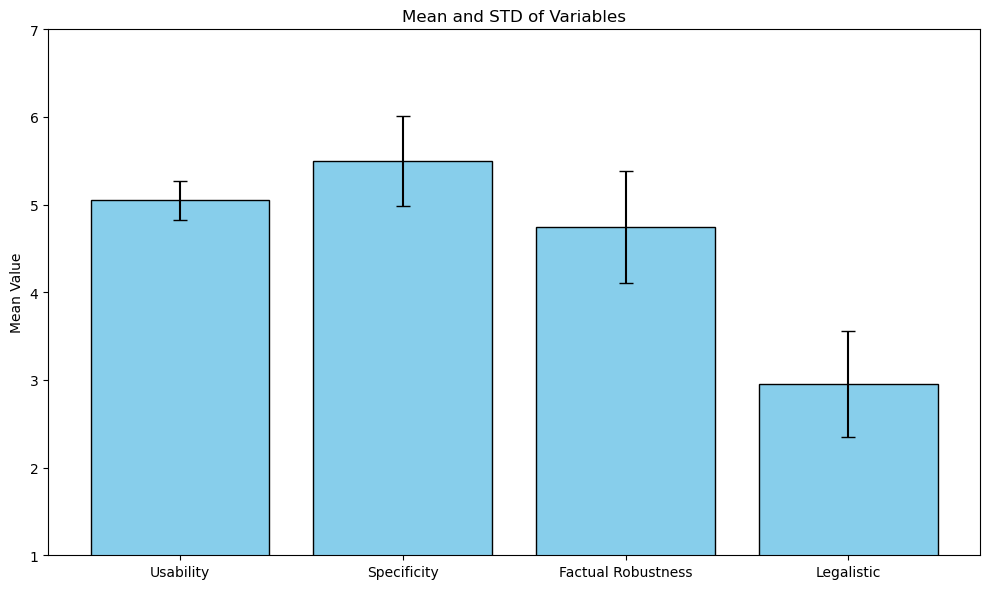

In [370]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_means_with_variation(df, label_dict, variation='std'):
    """
    Creates bar plots showing the mean values and variation for the specified variables,
    using a dictionary for both variable names and their custom labels.
    
    Args:
    - df: The DataFrame containing the data.
    - label_dict: Dictionary mapping variable names (columns) to custom labels.
    - variation: Type of variation to display ('std' for standard deviation, 'sem' for standard error).
    
    Returns:
    - None: Displays the plot.
    """
  # Extract variable names from the dictionary keys
    variables = list(label_dict.keys())
    
    # Calculate the mean and variation (std or sem)
    means = df[variables].mean()
    
    if variation == 'std':
        errors = df[variables].std()  # Standard deviation
    elif variation == 'sem':
        errors = df[variables].sem()  # Standard error
    else:
        raise ValueError("Invalid variation type. Choose 'std' or 'sem'.")
    
    # Replace the index (variable names) with the custom labels from the dictionary
    custom_labels = [label_dict[var] for var in means.index]
    
    # Plot the bar plot using matplotlib with error bars
    plt.figure(figsize=(10, 6))
    
    # Create a bar plot with error bars
    x_positions = np.arange(len(means))  # Positions for the bars
    plt.bar(x_positions, means, yerr=errors, capsize=5, color='skyblue', edgecolor='black')
    
    # Set custom x-tick labels
    plt.xticks(x_positions, custom_labels, rotation=0)
    
    # Set plot labels and title
    plt.ylabel('Mean Value')
    plt.title(f'Mean and {variation.upper()} of Variables')

    # Set the y-axis range from 1 to 7
    plt.ylim(1, 7)
    
    # Show the plot
    plt.tight_layout()

    plt.savefig(project_path("figures", f"Mean Ranking of Original Post.png"), bbox_inches='tight')

    # plt.show()

# Dictionary for variable names and custom labels
variables = {
    'use_rank_post': 'Usability',
    'spec_rank_post': 'Specificity',
    'fact_rank_post': 'Factual Robustness',
    'leg_rank_post': 'Legalistic'
}

# Call the function to plot the means with standard deviation
# plot_means_with_variation(df_answers, variables, variation='std')

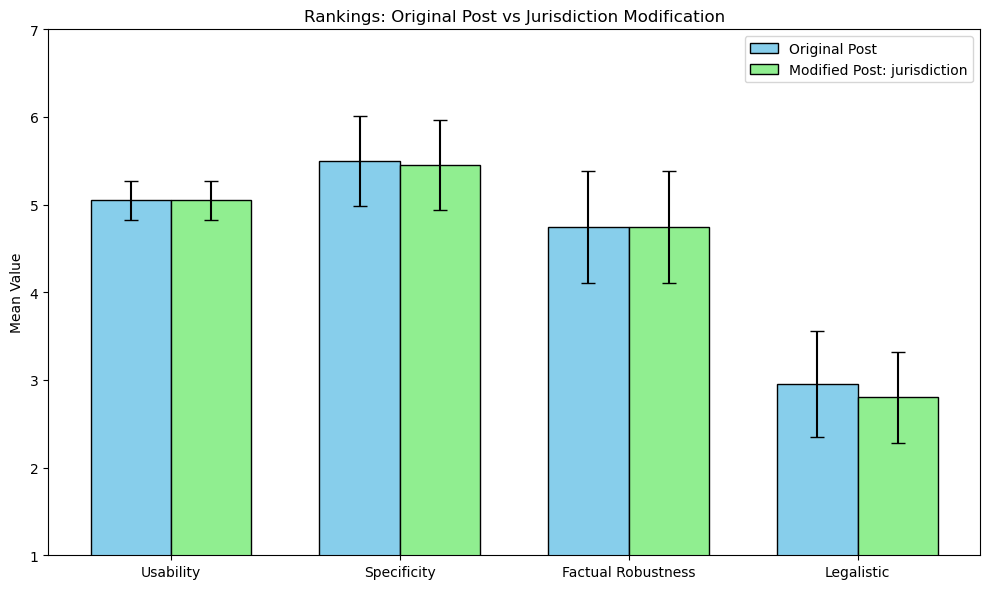

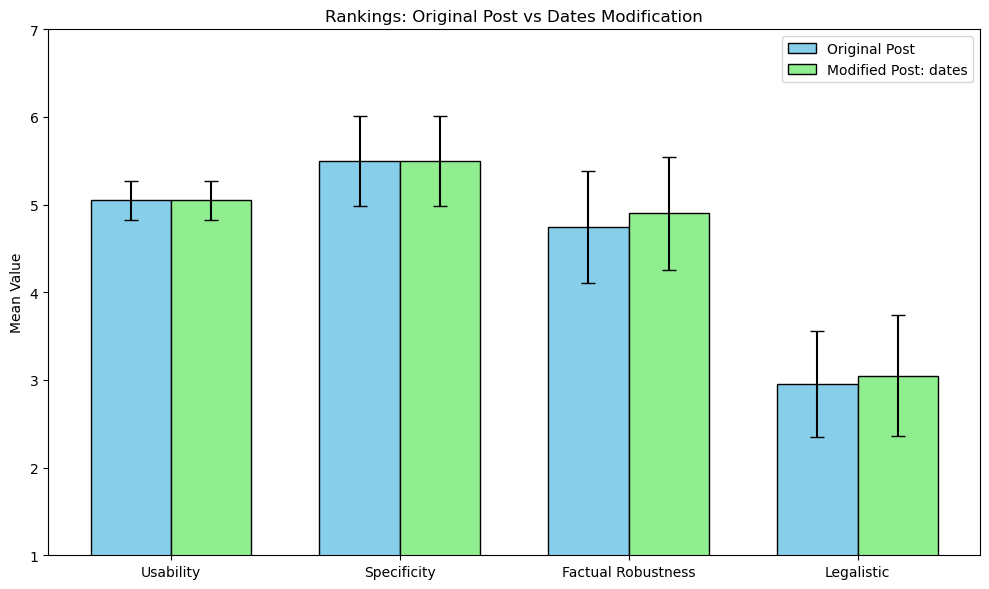

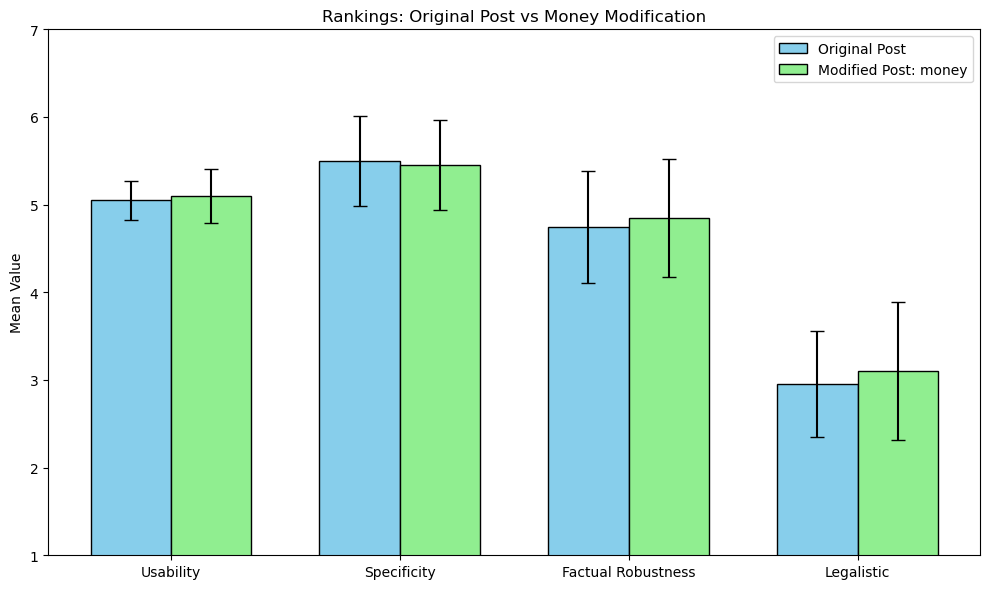

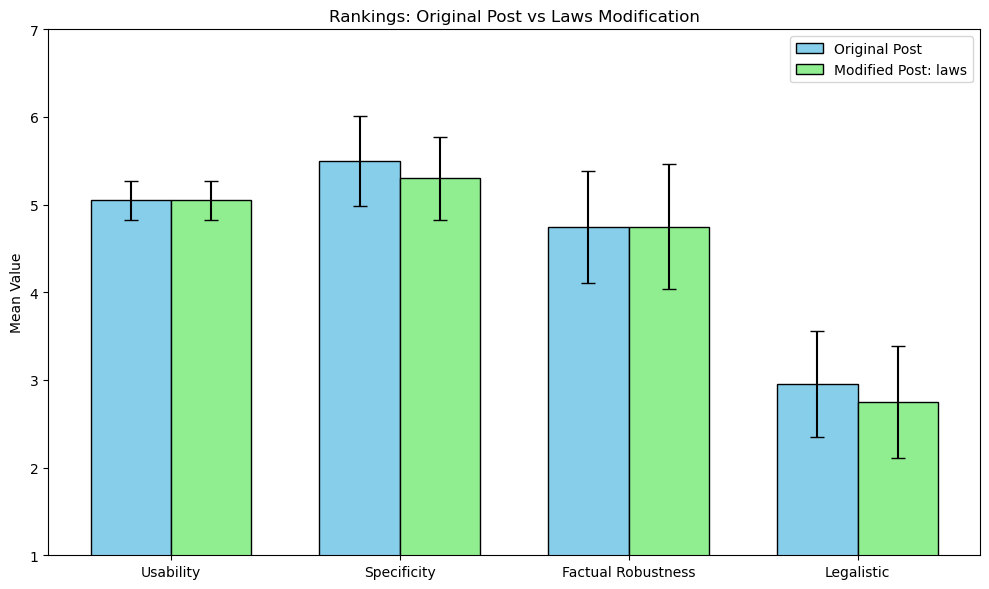

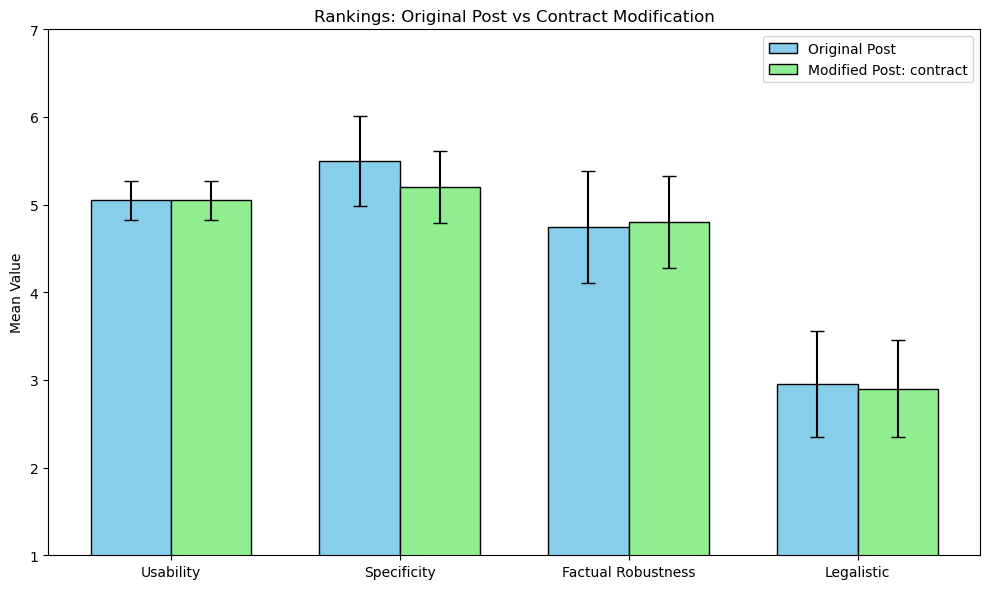

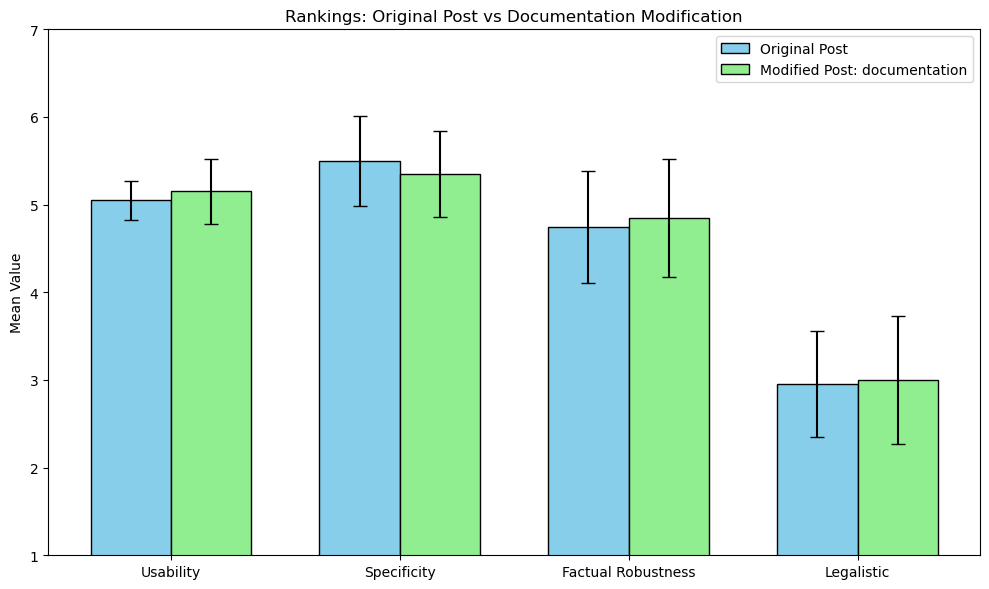

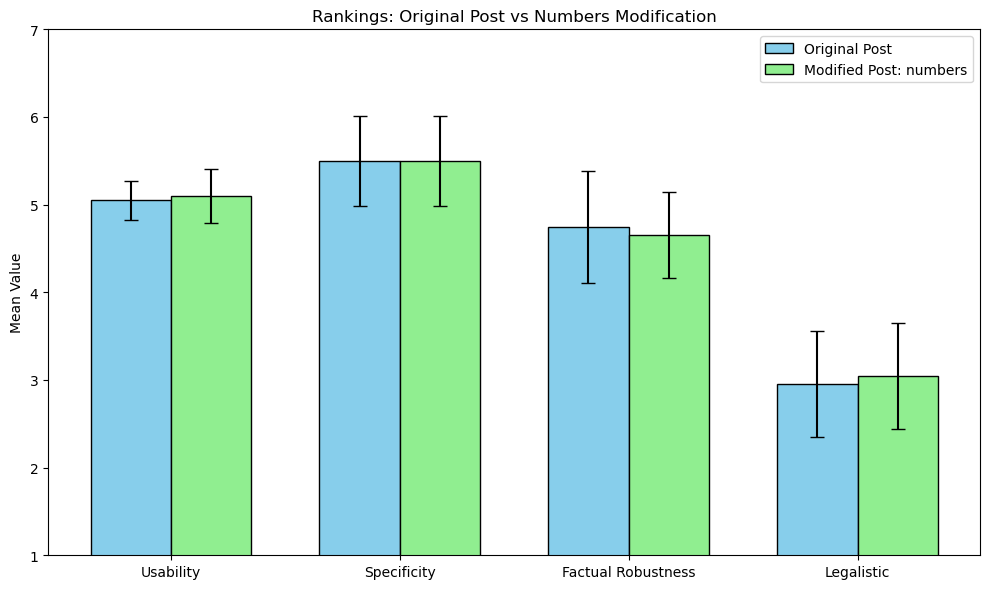

In [403]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def generate_variable_lists(custom_string):
    """
    Generates two lists of variables, with 'contract' replaced by a custom string in the second list (variables_B).
    
    Args:
    - custom_string: The string to plug into variables_B in place of 'contract'.
    
    Returns:
    - variables_A: List of variables for version A.
    - variables_B: List of variables for version B, with the custom string replacing 'contract'.
    """
    # Define the base for variables_A and variables_B without 'contract'
    base_variables = ['use_rank', 'spec_rank', 'fact_rank', 'leg_rank']
    
    # Generate variables_A (static version names)
    variables_A = [f"{base}_post" for base in base_variables]
    
    # Generate variables_B with the custom string replacing 'contract'
    variables_B = [f"{base}_transformed_post_{custom_string}" for base in base_variables]
    
    return variables_A, variables_B


def plot_paired_means_with_variation(df, modified_var, variation='std'):
    """
    Creates grouped bar plots showing the mean values and variation for paired variables
    (e.g., var1_A, var1_B, var2_A, var2_B) in two versions (A and B).
    
    Args:
    - df: The DataFrame containing the data.
    - variables_A: List of variable names for version A (e.g., ['var1_A', 'var2_A']).
    - variables_B: List of variable names for version B (e.g., ['var1_B', 'var2_B']).
    - labels: List of labels for the variables (e.g., ['Variable 1', 'Variable 2']).
    - variation: Type of variation to display ('std' for standard deviation, 'sem' for standard error).
    
    Returns:
    - None: Displays the plot.
    """
    # Labels for the variables
    labels = ['Usability', 'Specificity', 'Factual Robustness', 'Legalistic']

    variables_A, variables_B = generate_variable_lists(modified_var)

    # Calculate the mean and variation for each version
    means_A = df[variables_A].mean()
    means_B = df[variables_B].mean()
    
    if variation == 'std':
        errors_A = df[variables_A].std()  # Standard deviation for version A
        errors_B = df[variables_B].std()  # Standard deviation for version B
    elif variation == 'sem':
        errors_A = df[variables_A].sem()  # Standard error for version A
        errors_B = df[variables_B].sem()  # Standard error for version B
    else:
        raise ValueError("Invalid variation type. Choose 'std' or 'sem'.")
    
    # Set the number of variables
    num_vars = len(variables_A)
    
    # Set positions for the bars on the x-axis
    x_positions = np.arange(num_vars)
    width = 0.35  # Width of the bars
    
    # Plot the bars with error bars
    plt.figure(figsize=(10, 6))
    plt.bar(x_positions - width/2, means_A, width, yerr=errors_A, capsize=5, label='Original Post', color='skyblue', edgecolor='black')
    plt.bar(x_positions + width/2, means_B, width, yerr=errors_B, capsize=5, label=f'Modified Post: {modified_var}', color='lightgreen', edgecolor='black')
    
    # Set the labels and titles
    plt.xticks(x_positions, labels, rotation=0)
    plt.ylabel('Mean Value')
    plt.title(f'Rankings: Original Post vs {modified_var.capitalize()} Modification')
    
    # Add legend
    plt.legend()
    
    # Set y-axis limit to be 1-7 (if applicable, adjust if needed)
    plt.ylim(1, 7)
    
    # Display the plot
    plt.tight_layout()

    plt.savefig(project_path("figures", f"Mean Ranking of original vs {modified_var}.png"), bbox_inches='tight')

    # plt.show()


var_dict = {
    "jurisdiction": "may inform about the jurisdiction, such as the state or city",
    "dates": "is about specific dates, years, or periods of time",
    "money": "is about sums of money",
    "laws": "is about specific laws or regulations, including their names, references, or language",
    "contract": "is about specific lease and contract language",
    "documentation": "is related to documentation of communications, such as keeping emails, texts, recording phone calls, including the existence of documentation",
    "numbers": "contains numbers or measures, such as sizes, distances or heights (excluding dates or money)"
}

for var in var_dict.keys():
    plot_paired_means_with_variation(df_answers, var, variation='std')

use_rank
spec_rank
fact_rank
leg_rank


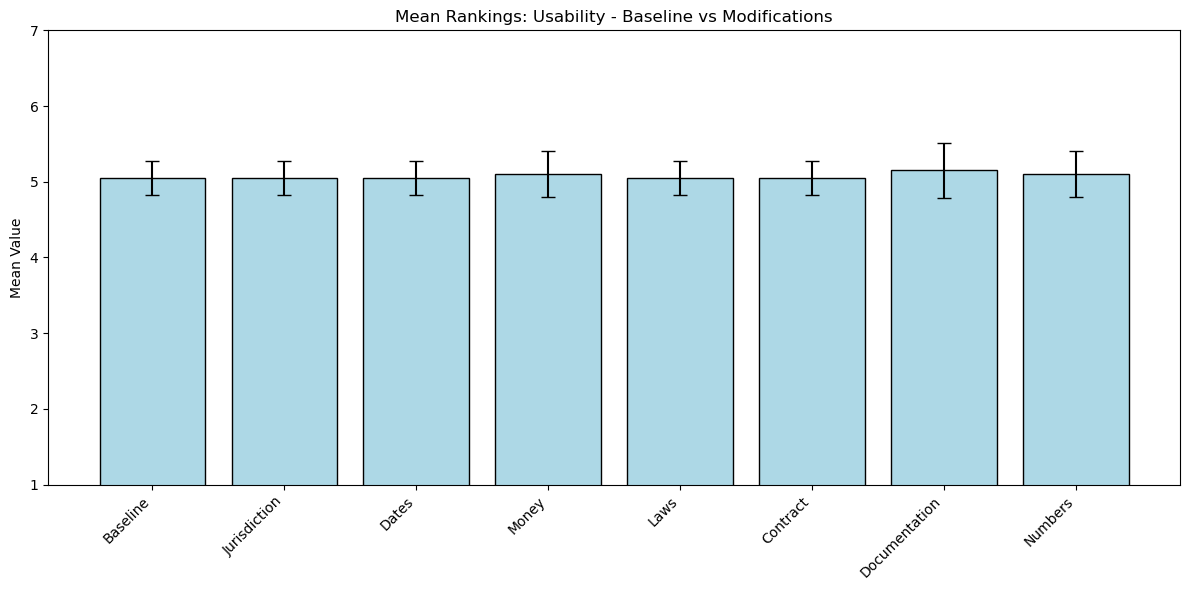

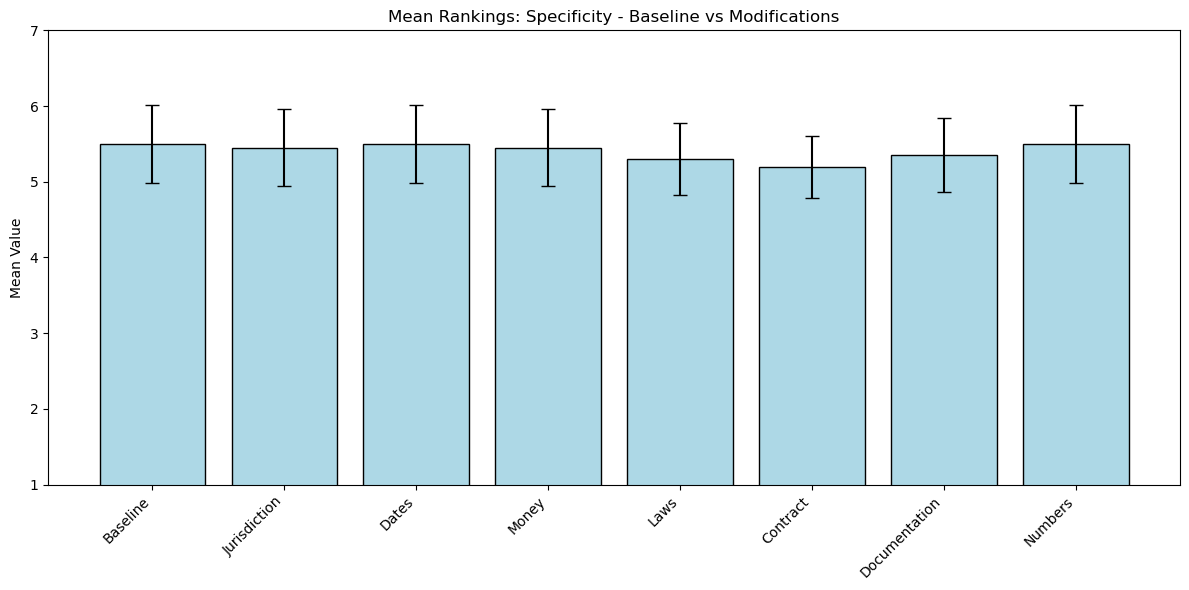

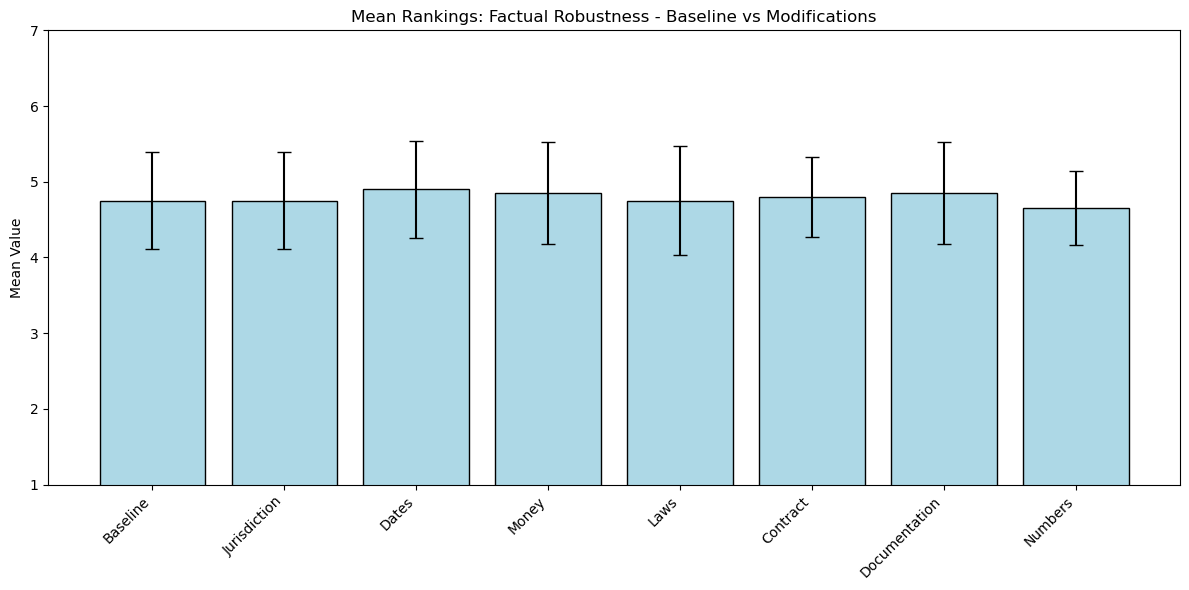

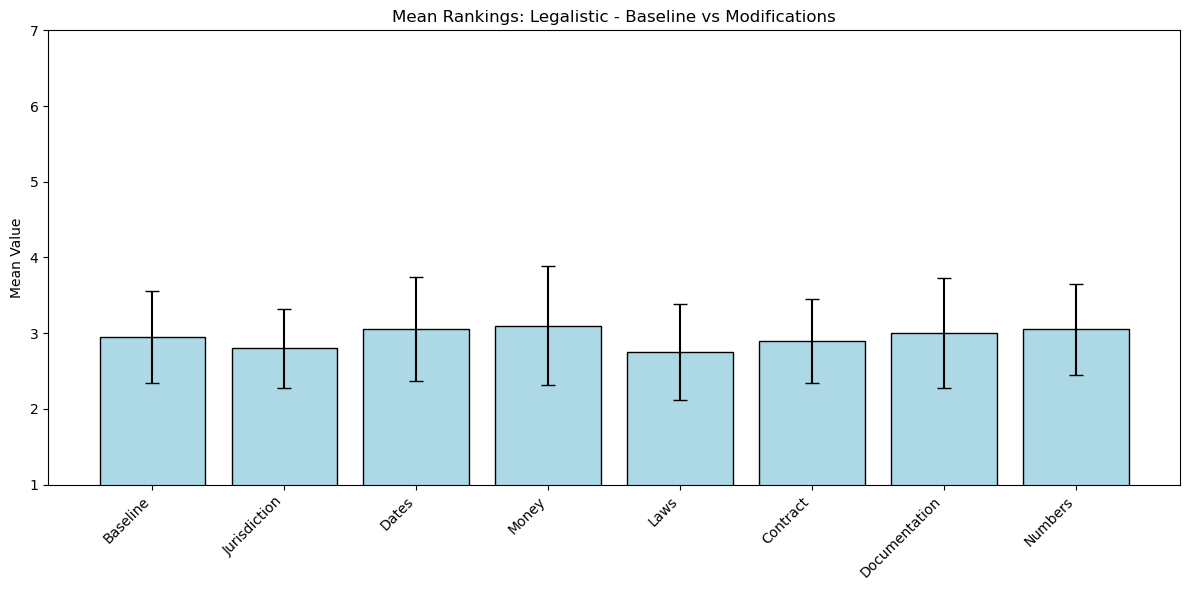

In [36]:
var_dict = {
    "jurisdiction": "may inform about the jurisdiction, such as the state or city",
    "dates": "is about specific dates, years, or periods of time",
    "money": "is about sums of money",
    "laws": "is about specific laws or regulations, including their names, references, or language",
    "contract": "is about specific lease and contract language",
    "documentation": "is related to documentation of communications, such as keeping emails, texts, recording phone calls, including the existence of documentation",
    "numbers": "contains numbers or measures, such as sizes, distances or heights (excluding dates or money)"
}

label_dict = {
    "use_rank": 'Usability',
    "spec_rank": 'Specificity',
    "fact_rank": 'Factual Robustness',
    "leg_rank": 'Legalistic'}


def plot_use_rank_with_modifications(df, label, variation='std'):
    """
    Creates a bar plot showing the mean values and variation for the use_rank variable
    in the baseline and 7 modified versions.
    
    Args:
    - df: The DataFrame containing the data.
    - variation: Type of variation to display ('std' for standard deviation, 'sem' for standard error).
    
    Returns:
    - None: Displays the plot.
    """
    # Define the base variable and the modified versions
    baseline_var = f'{label}_ques_text'
    modified_vars = [f"{label}_transformed_post_{mod}" for mod in var_dict.keys()]
    all_vars = [baseline_var] + modified_vars

    # Calculate the mean and variation for the variables
    means = df[all_vars].mean()
    
    if variation == 'std':
        errors = df[all_vars].std()  # Standard deviation
    elif variation == 'sem':
        errors = df[all_vars].sem()  # Standard error
    else:
        raise ValueError("Invalid variation type. Choose 'std' or 'sem'.")
    
    # Set positions for the bars on the x-axis
    x_positions = np.arange(len(all_vars))
    width = 0.8  # Width of the bars
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.bar(x_positions, means, width, yerr=errors, capsize=5, color='lightblue', edgecolor='black')
    
    # Set the labels and title
    labels = ['Baseline'] + [var.capitalize() for var in var_dict.keys()]
    plt.xticks(x_positions, labels, rotation=45, ha='right')
    plt.ylabel('Mean Value')
    plt.title(f'Mean Rankings: {label_dict[label]} - Baseline vs Modifications')
    
    # Set y-axis limit (adjust if necessary)
    plt.ylim(1, 7)
    
    # Display the plot
    plt.tight_layout()

    plt.savefig(project_path("figures", f"Mean Ranking of {label_dict[label]} - baseline vs modifications.png"), bbox_inches='tight')

    # plt.show()


# # Now, call the function to create the plot
for label in label_dict.keys():
    print(label)
    plot_use_rank_with_modifications(df_answers, label, variation='std')

# compare best response answers

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


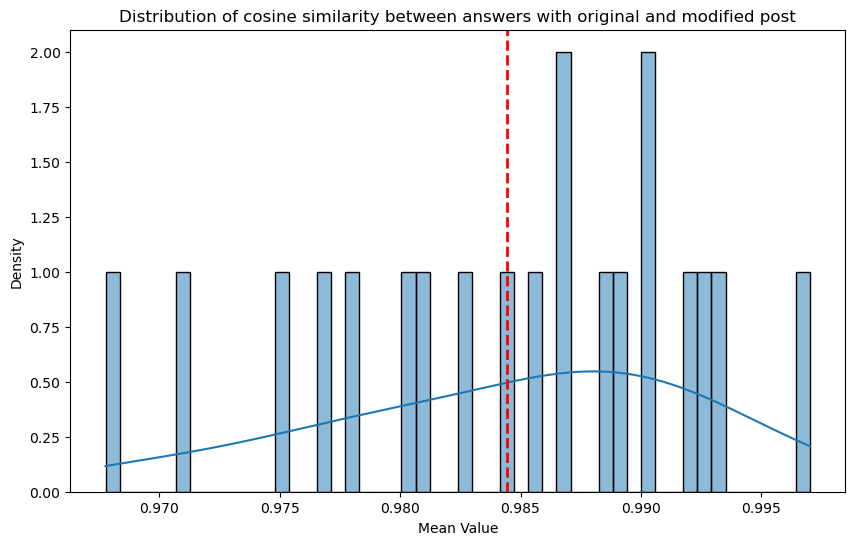

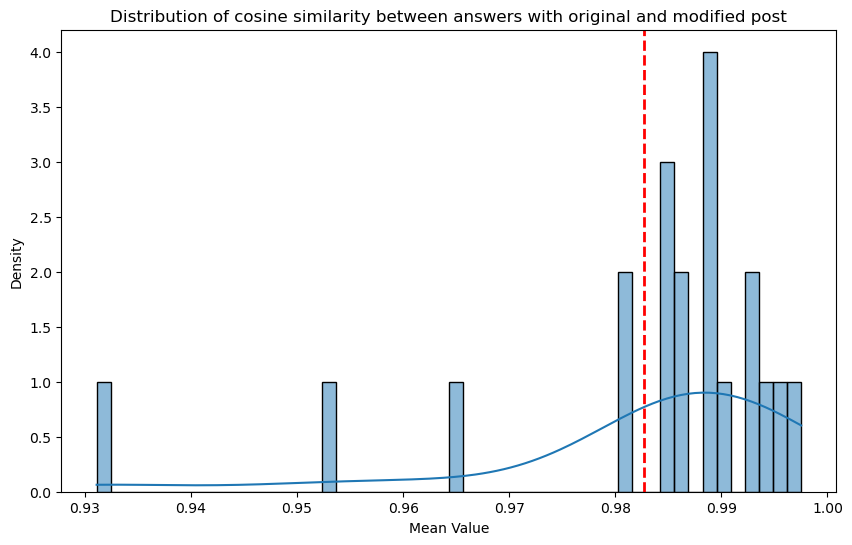

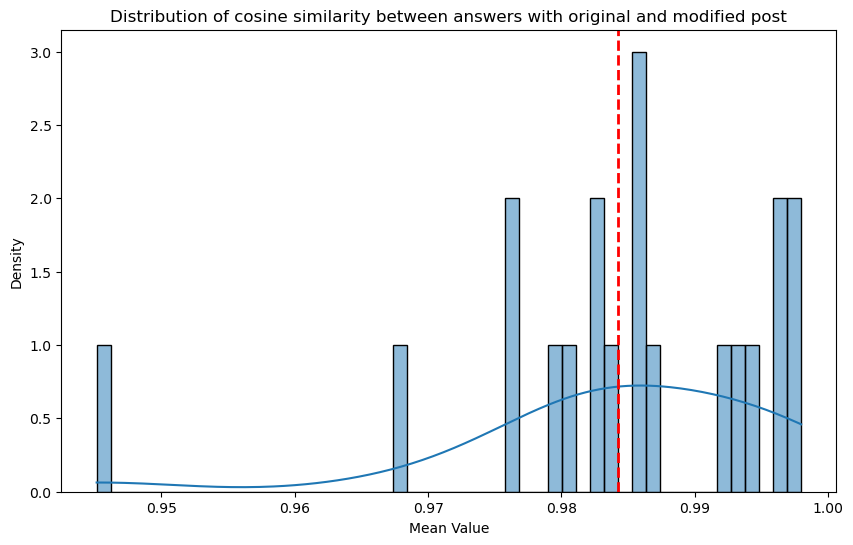

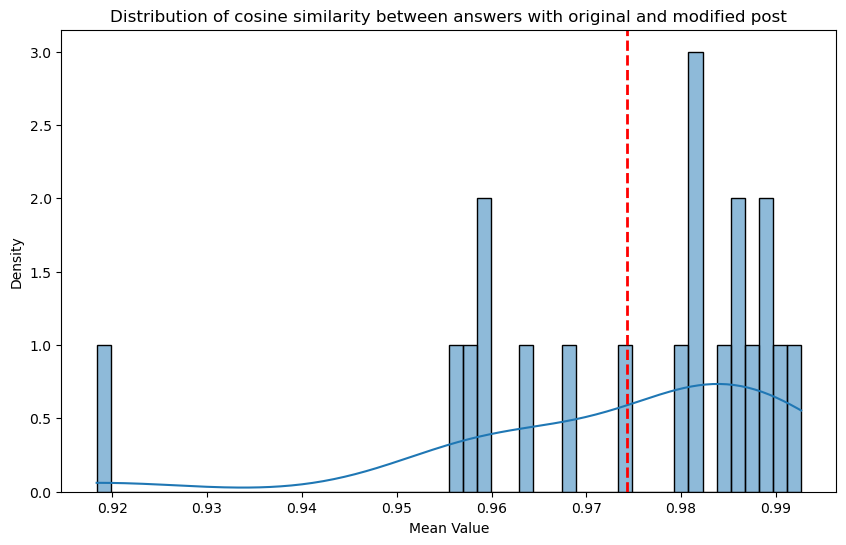

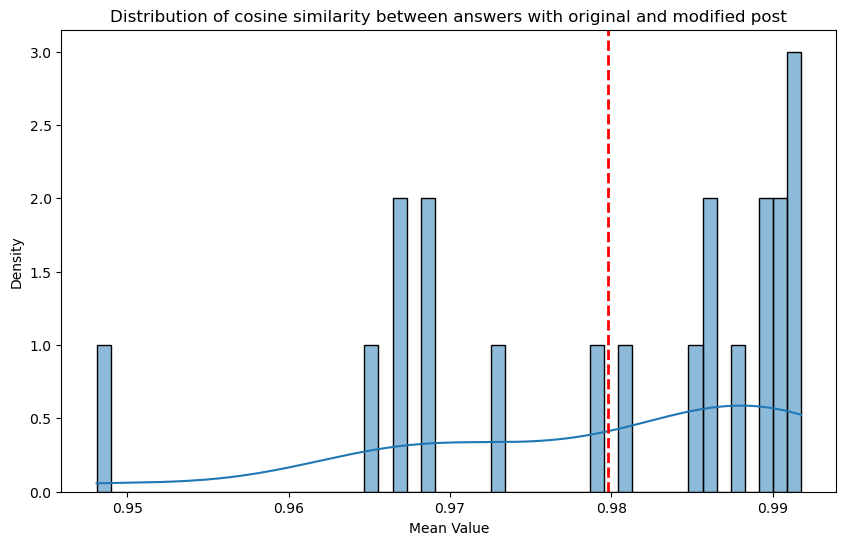

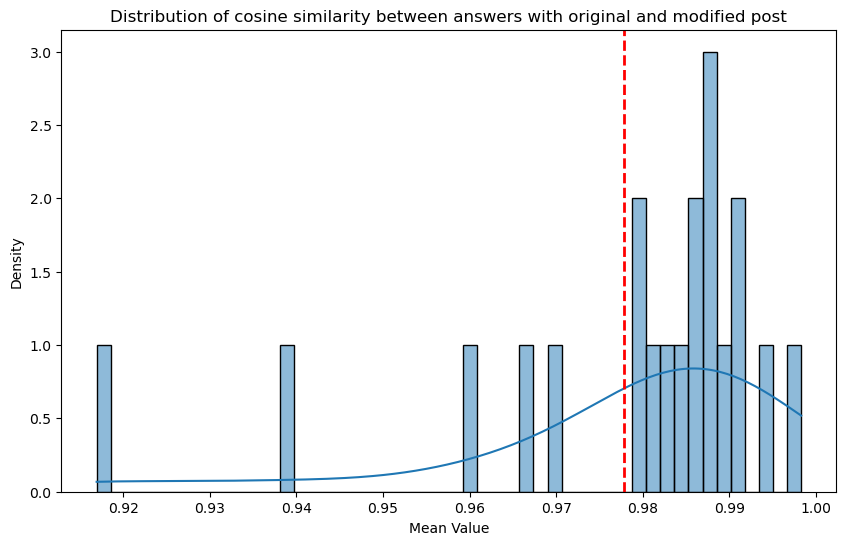

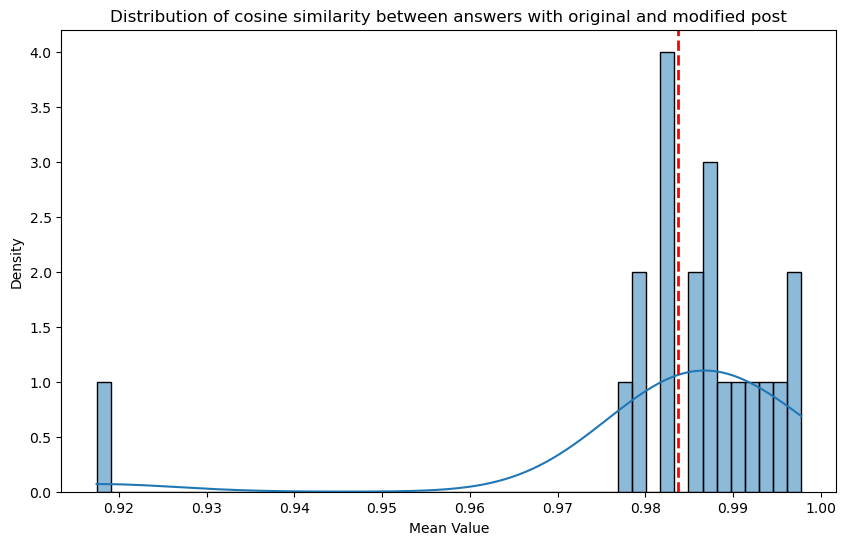

In [405]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import spacy.cli

# Download the model if not already installed
spacy.cli.download("en_core_web_md")

# Load a spaCy model with vectors (you can use 'en_core_web_md' or 'en_core_web_trf')
nlp = spacy.load("en_core_web_md")

# Function to convert a single text to its spaCy vector representation
def get_spacy_embedding(text):
    return nlp(text).vector

def calculate_embeddings(df,var):
        # Apply the embedding function to columns
    df['embedding_original'] = df['best_response_post'].apply(get_spacy_embedding)
    df[f'embedding_{var}'] = df[f'best_response_transformed_post_{var}'].apply(get_spacy_embedding)

    # Calculate cosine similarity for each pair of embeddings
    df['cosine_similarity_answer'] = df.apply(lambda row: cosine_similarity(
        [row['embedding_original']], [row[f'embedding_{var}']])[0][0], axis=1)

    return df

def generate_plot_cosine(df,modified_var):
    df = calculate_embeddings(df,var)
    
    overall_mean = df['cosine_similarity_answer'].mean()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df['cosine_similarity_answer'], kde=True, bins=50)
    plt.axvline(overall_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {overall_mean:.2f}')
    plt.title(f'Distribution of cosine similarity between answers with original and modified post')
    plt.xlabel('Mean Value')
    plt.ylabel('Density')
    plt.savefig(project_path("figures", f"cosine similarity between answers of original vs {modified_var}.png"), bbox_inches='tight')

    plt.show()

for var in var_dict.keys():
    generate_plot_cosine(df_answers, var)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


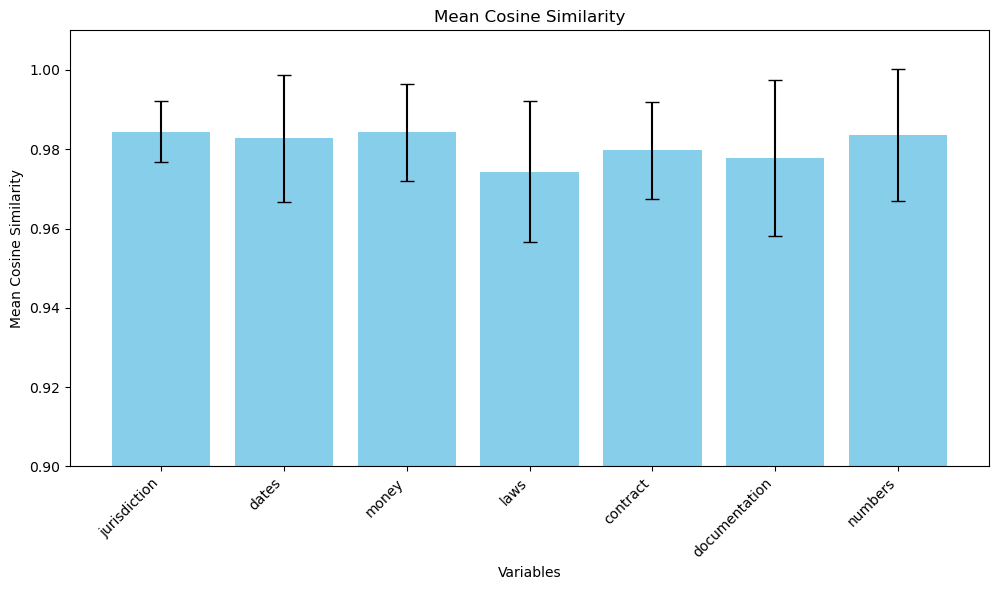

In [1092]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import spacy.cli
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Download the model if not already installed
spacy.cli.download("en_core_web_md")

# Load a spaCy model with vectors
nlp = spacy.load("en_core_web_md")

# Function to convert a single text to its spaCy vector representation
def get_spacy_embedding(text):
    return nlp(text).vector

def calculate_embeddings(df, var):
    # Apply the embedding function to columns
    df['embedding_original'] = df['best_response_post'].apply(get_spacy_embedding)
    df[f'embedding_{var}'] = df[f'best_response_transformed_post_{var}'].apply(get_spacy_embedding)

    # Calculate cosine similarity for each pair of embeddings
    df['cosine_similarity_answer'] = df.apply(lambda row: cosine_similarity(
        [row['embedding_original']], [row[f'embedding_{var}']])[0][0], axis=1)

    return df

# Store the means and standard deviations
cosine_means = []
cosine_stddevs = []
variables = []

# Calculate cosine similarity for each variable and store the mean and std dev
for var in var_dict.keys():
    df = calculate_embeddings(df_answers, var)
    mean_cosine = df['cosine_similarity_answer'].mean()
    stddev_cosine = df['cosine_similarity_answer'].std()
    
    cosine_means.append(mean_cosine)
    cosine_stddevs.append(stddev_cosine)
    variables.append(var)

# Create the bar plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(variables, cosine_means, yerr=cosine_stddevs, capsize=5, color='skyblue')
plt.xlabel('Variables')
plt.ylabel('Mean Cosine Similarity')
plt.title('Mean Cosine Similarity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.ylim(0.9, 1.01)

# Save the plot to a file
plt.savefig(project_path("figures", "mean_cosine_similarity_bar_plot.png"), bbox_inches='tight')

# Show the plot
plt.show()



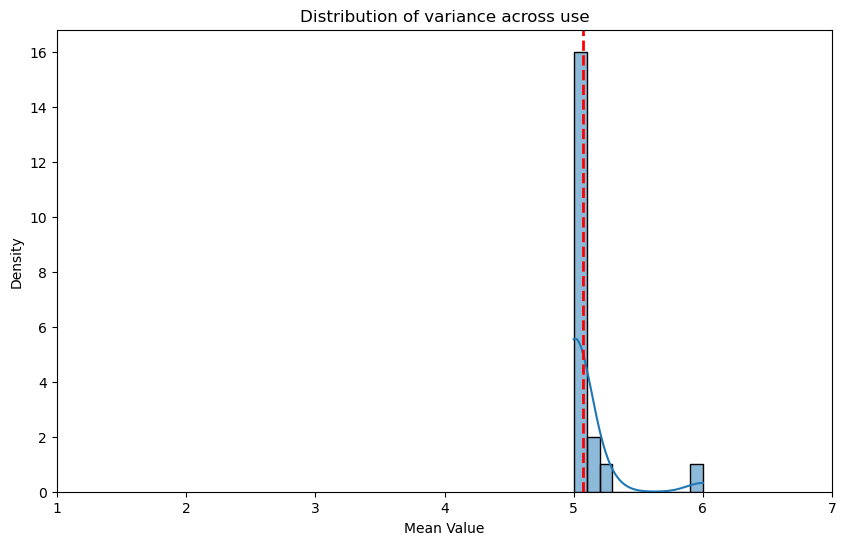

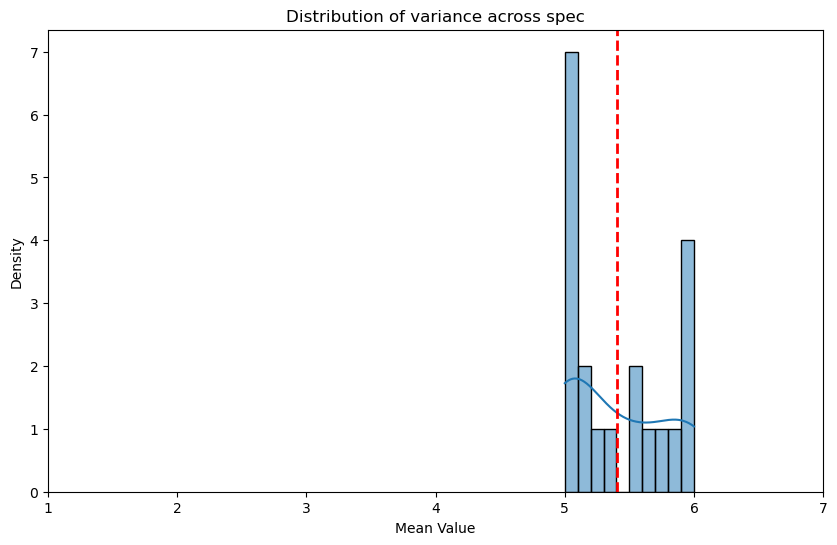

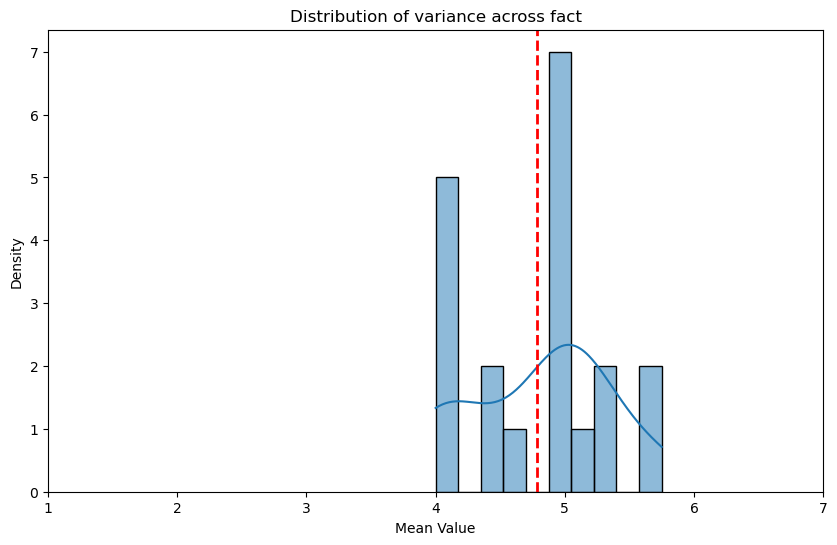

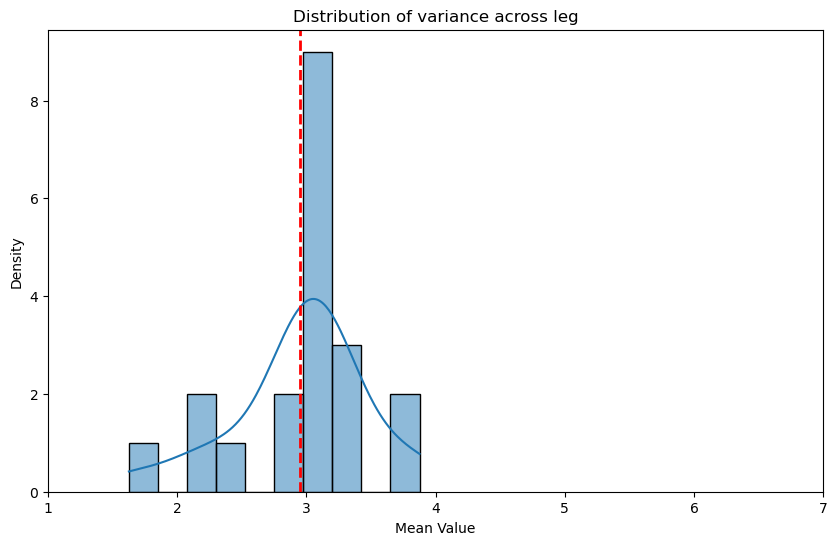

In [433]:
def plot_dist(df, col):
    list = [f'{col}_rank_post']
    for var in var_dict.keys():
        list.append(f'{col}_rank_transformed_post_{var}')
    means = df[list].mean(axis=1)
    overall_mean = means.mean()
    plt.figure(figsize=(10, 6))
    sns.histplot(means, kde=True, bins=10)
    plt.title(f'Distribution of variance across {col}')
    plt.axvline(overall_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {overall_mean:.2f}')
    plt.xlabel('Mean Value')
    plt.ylabel('Density')
    plt.xlim(1, 7)
    plt.savefig(project_path("figures", f"variance across {col}.png"), bbox_inches='tight')

for col in ['use','spec','fact','leg']:
    plot_dist(df_answers, col)

# regression

In [1082]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np

def run_regression(df,col):
    list = [f'{col}_rank_post']
    for var in var_dict.keys():
        list.append(f'{col}_rank_transformed_post_{var}')
        
    df1 = df[list]
    
    # Reshape the data from wide to long format
    df_long = pd.melt(df1, var_name='transformation', value_name='use_rank', ignore_index=False)
    
    # Map the baseline 'use_rank_post' to the baseline group
    df_long['baseline'] = df_long['transformation'].apply(lambda x: 1 if x == 'use_rank_post' else 0)
    
    # Create dummy variables for the transformations, leaving the baseline as the reference
    df_long['is_jurisdiction'] = df_long['transformation'].apply(lambda x: 1 if 'jurisdiction' in x else 0)
    df_long['is_dates'] = df_long['transformation'].apply(lambda x: 1 if 'dates' in x else 0)
    df_long['is_money'] = df_long['transformation'].apply(lambda x: 1 if 'money' in x else 0)
    df_long['is_laws'] = df_long['transformation'].apply(lambda x: 1 if 'laws' in x else 0)
    df_long['is_contract'] = df_long['transformation'].apply(lambda x: 1 if 'contract' in x else 0)
    df_long['is_documentation'] = df_long['transformation'].apply(lambda x: 1 if 'documentation' in x else 0)
    df_long['is_numbers'] = df_long['transformation'].apply(lambda x: 1 if 'numbers' in x else 0)
    
    # Ensure all dummy variables and 'use_rank' are numeric
    X = df_long[['is_jurisdiction', 'is_dates', 'is_money', 'is_laws', 'is_contract', 'is_documentation', 'is_numbers']]
    X = sm.add_constant(X)  # Add an intercept
    y = df_long['use_rank']
    
    # Check if any of the columns have non-numeric values
    print(X.dtypes)
    print(y.dtypes)
    
    # Fit the regression model
    model = sm.OLS(y, X)
    results = model.fit()

    # Display the regression results in LaTeX format
    latex_table = results.summary2().as_latex()
    print(latex_table)
    
    # # Display the regression results
    # print(results.summary())

    return results

# Function to plot the coefficients
def plot_regression_coefficients(results,col):
    """
    Plots the regression coefficients from a statsmodels OLS regression result.
    
    Args:
    - results: The fitted OLS model result.
    
    Returns:
    - None: Displays the plot.
    """
    # Get the coefficients and standard errors
    coefficients = results.params
    errors = results.bse  # Standard errors
    
    # Get the names of the coefficients (excluding the intercept)
    labels = coefficients.index[1:]  # Exclude the intercept
    coeff_values = coefficients[1:]  # Exclude the intercept coefficient
    error_values = errors[1:]  # Exclude the intercept error

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, coeff_values, yerr=error_values, capsize=5, color='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Transformation')
    plt.ylabel('Coefficient Value')
    plt.title(f'Regression Coefficients for {col}')
    
    # Add a horizontal line at y=0 for reference
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    
    # Rotate the x-axis labels if needed
    plt.xticks(rotation=45, ha='right')
    
    # Display the plot
    plt.tight_layout()
    plt.savefig(project_path("figures", f"regression_coefs_for_{col}.png"), bbox_inches='tight')

    plt.show()

def regressions(df,col):
    results = run_regression(df,col)
    plot_regression_coefficients(results,col)

In [1084]:
run_regression(df_answers, 'use')

const               float64
is_jurisdiction       int64
is_dates              int64
is_money              int64
is_laws               int64
is_contract           int64
is_documentation      int64
is_numbers            int64
dtype: object
int64
\begin{table}
\caption{Results: Ordinary least squares}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS              & Adj. R-squared:     & -0.027    \\
Dependent Variable: & use\_rank        & AIC:                & 40.2346   \\
Date:               & 2024-09-19 15:33 & BIC:                & 64.8360   \\
No. Observations:   & 160              & Log-Likelihood:     & -12.117   \\
Df Model:           & 7                & F-statistic:        & 0.3984    \\
Df Residuals:       & 152              & Prob (F-statistic): & 0.902     \\
R-squared:          & 0.018            & Scale:              & 0.071711  \\
\hline
\end{tabular}
\end{center}

\begin{center}
\begin{tabular}{lrrrrrr}
\hline
                  &   Coef. & Std

const               float64
is_jurisdiction       int64
is_dates              int64
is_money              int64
is_laws               int64
is_contract           int64
is_documentation      int64
is_numbers            int64
dtype: object
int64
                            OLS Regression Results                            
Dep. Variable:               use_rank   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.3984
Date:                Wed, 18 Sep 2024   Prob (F-statistic):              0.902
Time:                        14:51:08   Log-Likelihood:                -12.117
No. Observations:                 160   AIC:                             40.23
Df Residuals:                     152   BIC:                             64.84
Df Model:                           7                                         
Covariance Type:            nonrobust        

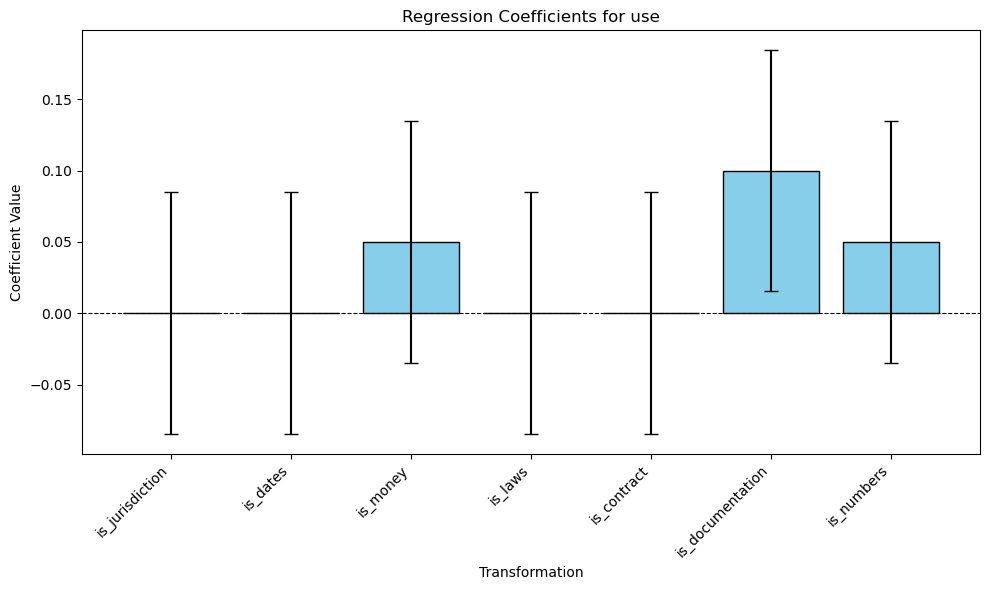

const               float64
is_jurisdiction       int64
is_dates              int64
is_money              int64
is_laws               int64
is_contract           int64
is_documentation      int64
is_numbers            int64
dtype: object
int64
                            OLS Regression Results                            
Dep. Variable:               use_rank   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.028
Date:                Wed, 18 Sep 2024   Prob (F-statistic):              0.414
Time:                        14:51:09   Log-Likelihood:                -109.56
No. Observations:                 160   AIC:                             235.1
Df Residuals:                     152   BIC:                             259.7
Df Model:                           7                                         
Covariance Type:            nonrobust        

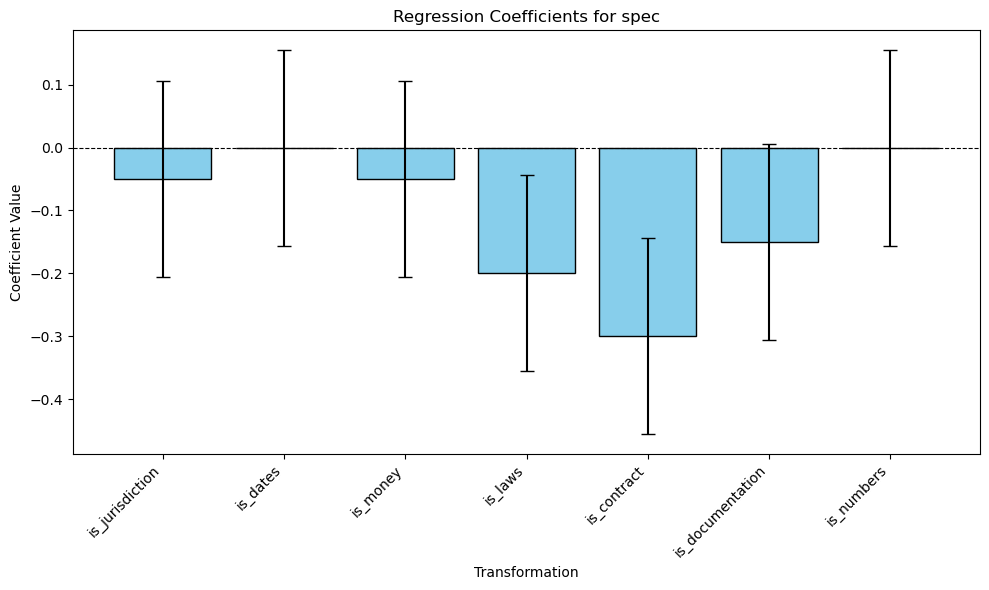

const               float64
is_jurisdiction       int64
is_dates              int64
is_money              int64
is_laws               int64
is_contract           int64
is_documentation      int64
is_numbers            int64
dtype: object
int64
                            OLS Regression Results                            
Dep. Variable:               use_rank   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.3172
Date:                Wed, 18 Sep 2024   Prob (F-statistic):              0.945
Time:                        14:51:10   Log-Likelihood:                -148.43
No. Observations:                 160   AIC:                             312.9
Df Residuals:                     152   BIC:                             337.5
Df Model:                           7                                         
Covariance Type:            nonrobust        

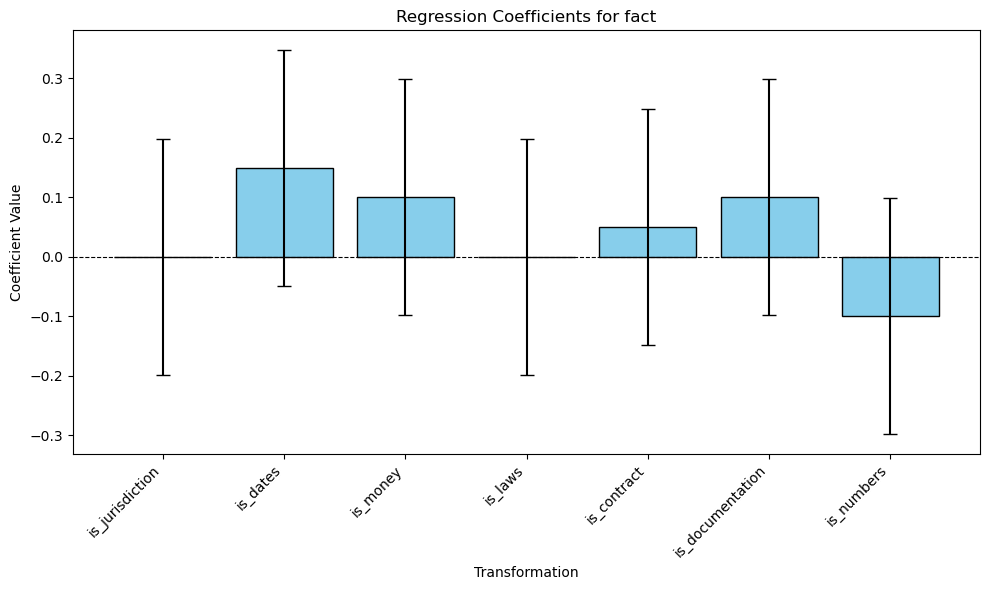

const               float64
is_jurisdiction       int64
is_dates              int64
is_money              int64
is_laws               int64
is_contract           int64
is_documentation      int64
is_numbers            int64
dtype: object
int64
                            OLS Regression Results                            
Dep. Variable:               use_rank   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.7535
Date:                Wed, 18 Sep 2024   Prob (F-statistic):              0.627
Time:                        14:51:10   Log-Likelihood:                -152.97
No. Observations:                 160   AIC:                             321.9
Df Residuals:                     152   BIC:                             346.5
Df Model:                           7                                         
Covariance Type:            nonrobust        

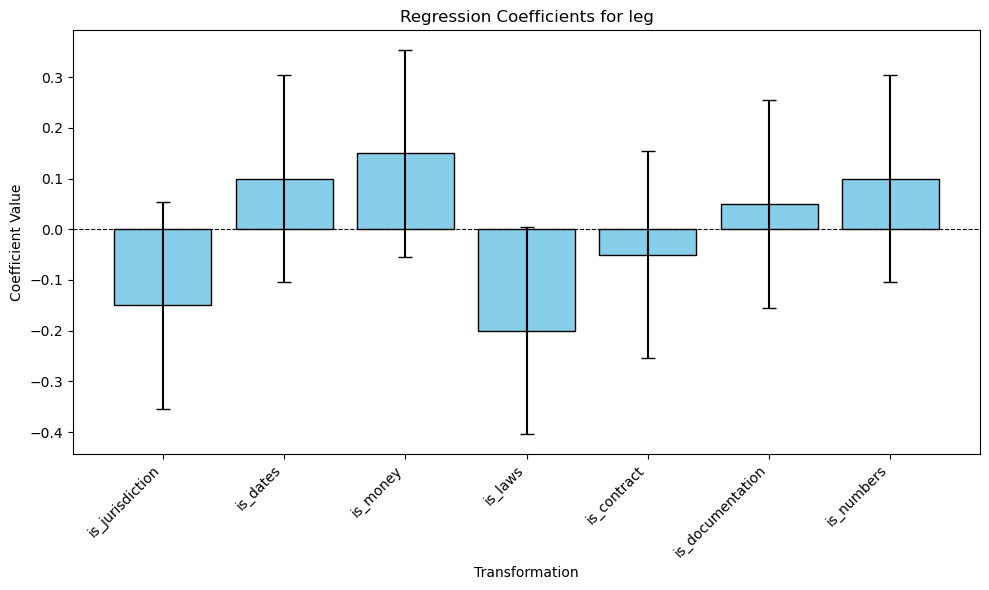

In [490]:
for col in ['use','spec','fact','leg']:
    regressions(df_answers, col)

# analyze missing factors

In [963]:
df_answers.columns = df_answers.columns.str.replace('ques_text', 'post')

In [215]:
import ast
import itertools
from transformers import pipeline
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os

# Create a big list from a DataFrame column containing lists or strings
def create_list(df, var):
    missing_vars_list = []
    
    for item in df[var]:
        # Try to parse strings as lists
        if isinstance(item, str):
            try:
                item = ast.literal_eval(item)
            except (ValueError, SyntaxError):
                pass  # Keep as a string if it's not a list
        
        # Check the type using type()
        if isinstance(item, list):
            missing_vars_list.extend(item)
        else:
            missing_vars_list.append(item)
    
    # Flatten the list of lists into one big list
    missing_vars_list = list(itertools.chain.from_iterable(
        [item if isinstance(item, list) else [item] for item in missing_vars_list]))
    
    # Split any items containing '@' into separate items
    final_list = []
    for item in missing_vars_list:
        if isinstance(item, str):
            split_items = [sub_item.strip() for sub_item in item.split('@') if sub_item]
            final_list.extend(split_items)
    return final_list

# Classify categories using Hugging Face zero-shot classification
def classify_categories(final_list):
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    candidate_labels = list(var_dict.keys())
    
    classified_items = {}
    for item in final_list:
        result = classifier(item, candidate_labels)
        top_labels = result['labels'][:2]  # Get top 2 labels
        classified_items[item] = top_labels
    return classified_items

# Plot categories side-by-side for two variables
def plot_categories_side_by_side(df, var_name1, var_name2):
    var1 = f'var_missing_{var_name1}_list'
    var2 = f'var_missing_transformed_{var_name1}_{var_name2}_list'

    # Get lists and classify categories for both variables
    final_list1 = create_list(df, var1)
    classified_items1 = classify_categories(final_list1)
    
    final_list2 = create_list(df, var2)
    classified_items2 = classify_categories(final_list2)
    
    # Count category frequencies for both variables
    category_counts1 = Counter()
    for categories in classified_items1.values():
        category_counts1.update(categories)
    
    category_counts2 = Counter()
    for categories in classified_items2.values():
        category_counts2.update(categories)
    
    # Ensure both sets of categories are aligned
    all_categories = list(set(list(category_counts1.keys()) + list(category_counts2.keys())))
    counts1 = [category_counts1.get(cat, 0) for cat in all_categories]
    counts2 = [category_counts2.get(cat, 0) for cat in all_categories]
    
    # Plot side-by-side bar chart
    bar_width = 0.35
    index = np.arange(len(all_categories))

    plt.figure(figsize=(12, 7))
    
    # Bars for var1 with custom label for legend
    plt.bar(index, counts1, bar_width, label='Original Post', color='skyblue')
    
    # Bars for var2 with custom label for legend
    plt.bar(index + bar_width, counts2, bar_width, label=f'Modified Post: {var_name2.capitalize()}', color='salmon')
    
    # Labels and title
    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Classified Categories: Original {var_name1.capitalize()} vs {var_name2.capitalize()} Modification')
    plt.xticks(index + bar_width / 2, all_categories, rotation=45, ha='right')
    plt.legend()
    
    plt.tight_layout()
    
    # Ensure directory exists and save the plot
    save_dir = os.path.join("G:", os.sep, "My Drive", "Work", "Working Papers", "LLM and Legal Advice", "figures")
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"Frequency of Classified Categories original {var_name1} vs {var_name2}.png"), bbox_inches='tight')


C:\Users\mitha\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\mitha\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\mitha\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depract

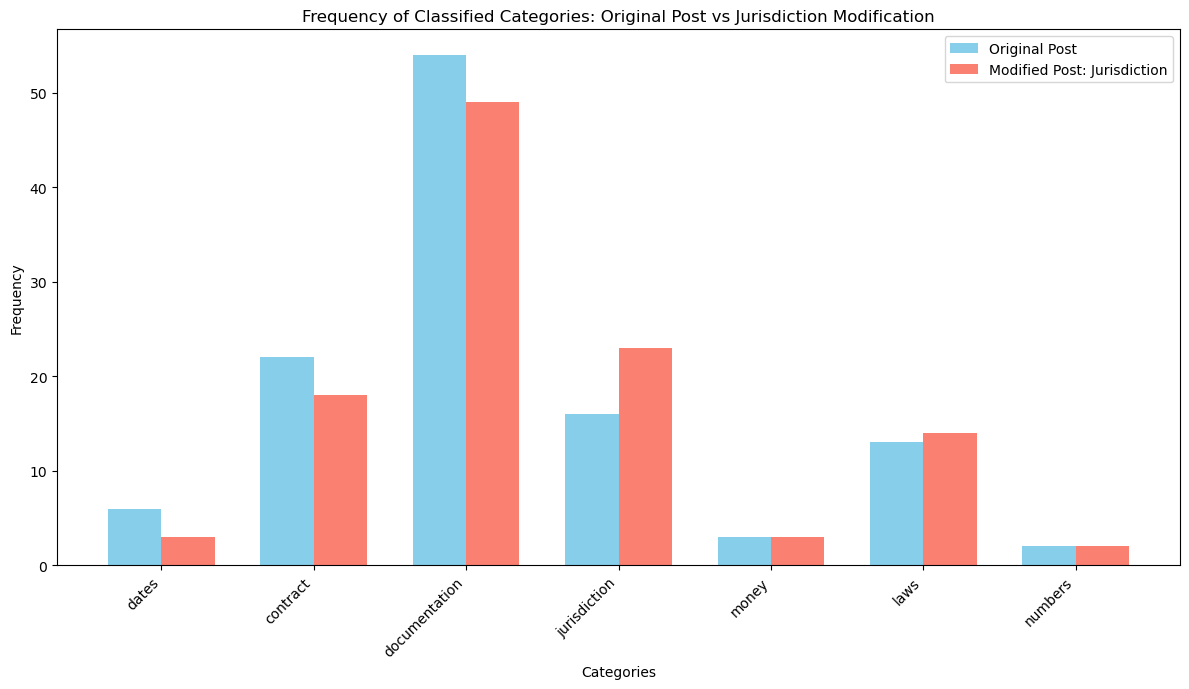

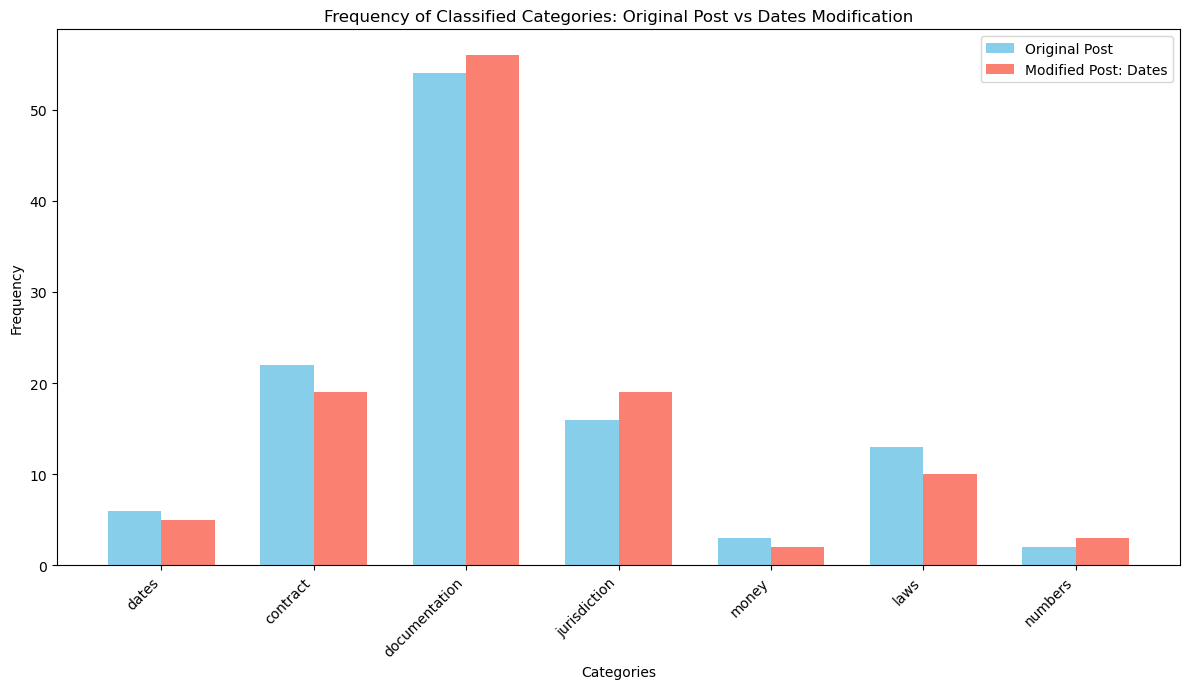

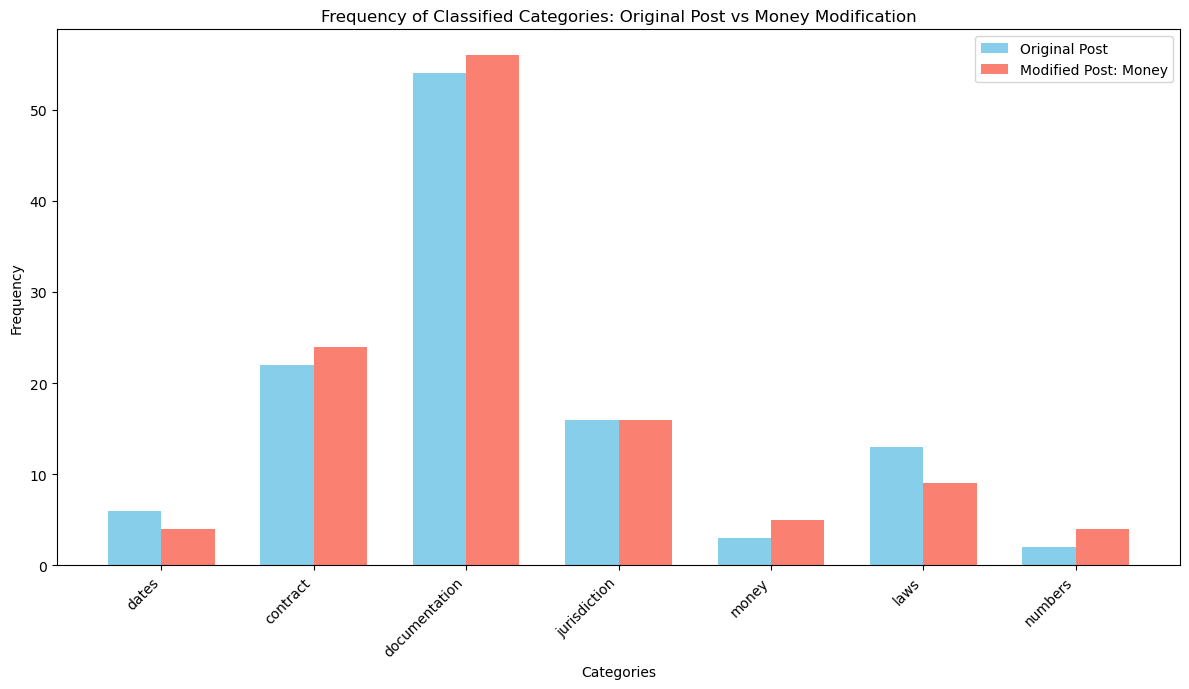

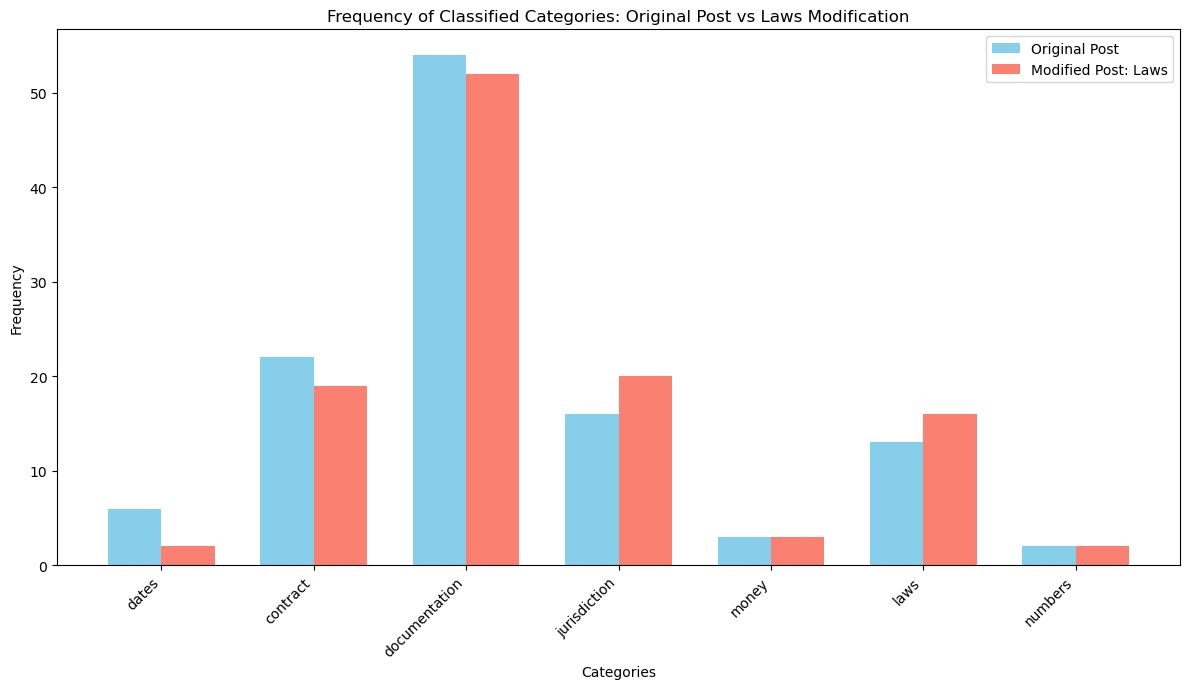

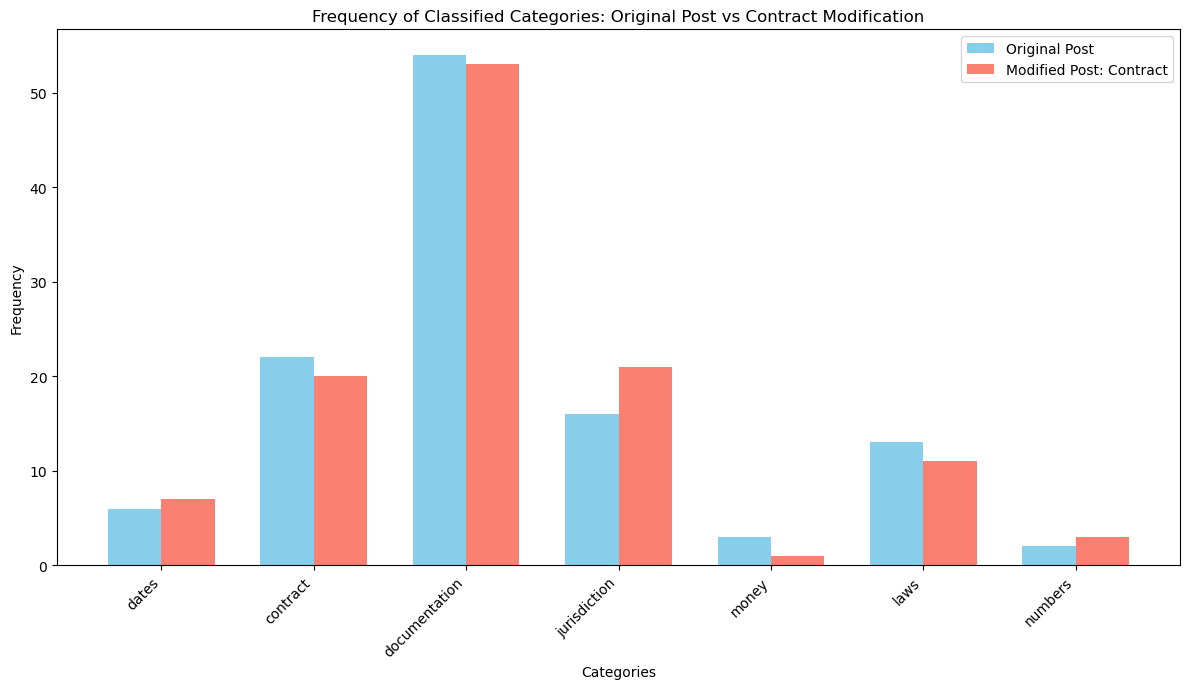

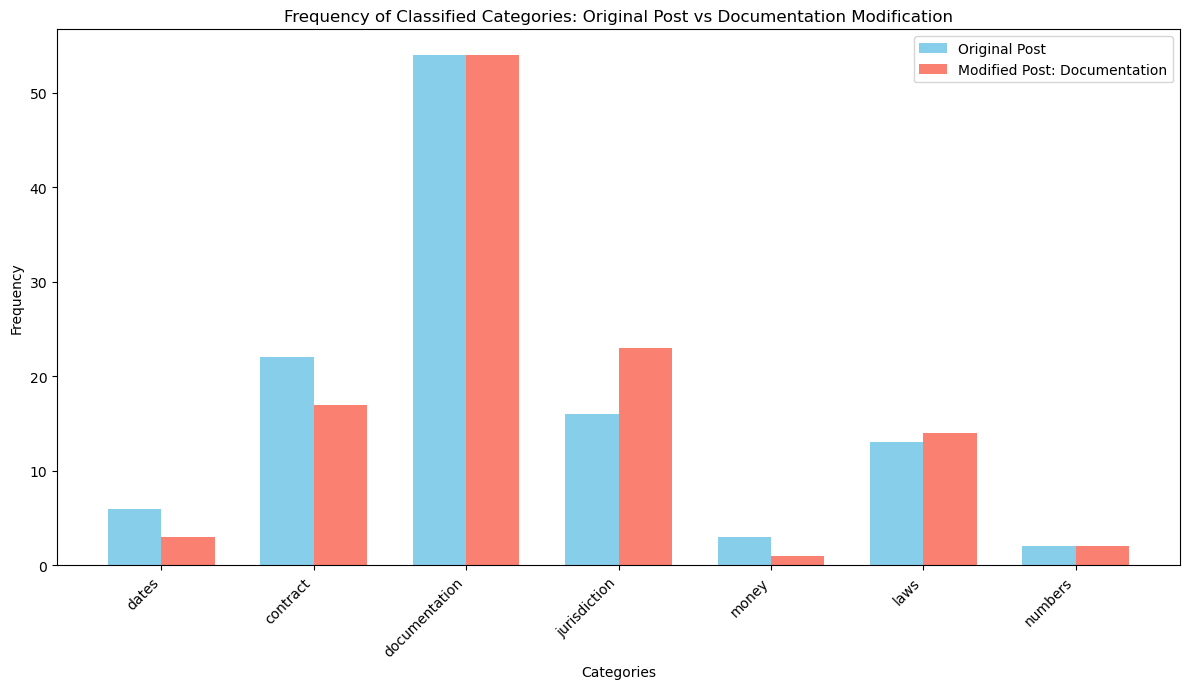

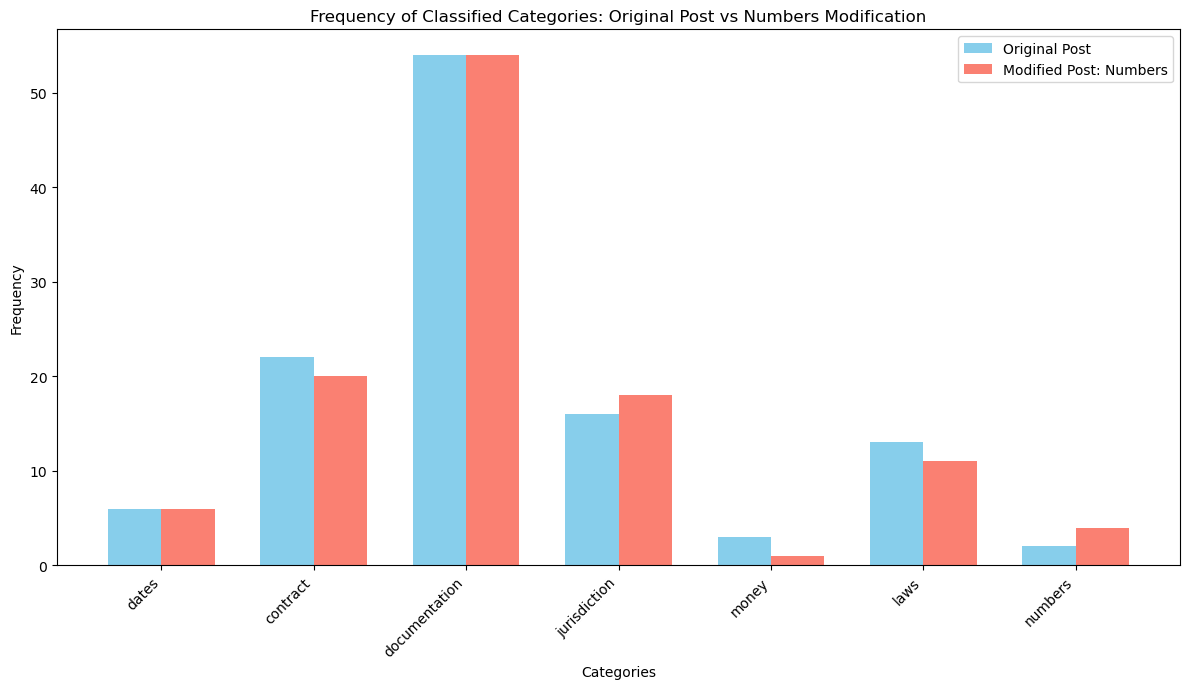

In [1075]:
for key in var_dict:
    plot_categories_side_by_side(df_answers, 'post', key)

In [219]:
# Function to calculate standard error for frequency counts
def calculate_standard_error(counts):
    return np.sqrt(counts) / np.sqrt(len(counts))  # Simplified assumption for error calculation

# Plot two bars per variable: Original Post vs Corresponding Modification with calculated error bars
def plot_baseline_vs_modifications_with_calculated_errors(df):
    fig, ax = plt.subplots(figsize=(14, 7))
    bar_width = 0.35  # Adjust bar width for two bars per variable
    x_positions = np.arange(len(var_dict))  # Position for each variable

    # Loop through each variable (modification) and plot against the baseline
    for i, (key, desc) in enumerate(var_dict.items()):
        var1 = 'var_missing_post_list'
        var2 = f'var_missing_transformed_post_{key}_list'
        
        # Get classified categories for the baseline (original post)
        final_list1 = create_list(df, var1)
        classified_items1 = classify_categories(final_list1)
        category_counts1 = Counter()
        for categories in classified_items1.values():
            category_counts1.update(categories)
        
        # Get classified categories for the corresponding modification
        final_list2 = create_list(df, var2)
        classified_items2 = classify_categories(final_list2)
        category_counts2 = Counter()
        for categories in classified_items2.values():
            category_counts2.update(categories)
        
        # Only plot the counts for the current variable being modified
        count_baseline = category_counts1.get(key, 0)
        count_modification = category_counts2.get(key, 0)

        # Calculate standard error for both baseline and modification
        error_baseline = calculate_standard_error([count_baseline])
        error_modification = calculate_standard_error([count_modification])

        # Plot bars with calculated error bars for baseline and corresponding modification
        ax.bar(x_positions[i], count_baseline, bar_width, color='skyblue', yerr=error_baseline, capsize=5)
        ax.bar(x_positions[i] + bar_width, count_modification, bar_width, color='lightgreen', yerr=error_modification, capsize=5)

    # Set labels, title, and formatting for the plot
    ax.set_xlabel('Categories')
    ax.set_ylabel('Frequency')
    ax.set_title('Category Frequency: Original Post vs Modifications')
    ax.set_xticks(x_positions + bar_width / 2)
    ax.set_xticklabels(var_dict.keys(), rotation=45, ha='right')
    
    # Custom legend with skyblue for Original Post and green for Modification
    ax.legend(['Original Post', 'Modification'], loc='upper right')

    plt.tight_layout()

    # Ensure directory exists and save the plot
    save_dir = os.path.join("G:", os.sep, "My Drive", "Work", "Working Papers", "LLM and Legal Advice", "figures")
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, "Frequency_of_Classified_Categories_Post_vs_Modifications_Calculated_Errors.png"), bbox_inches='tight')

C:\Users\mitha\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


ValueError: You must include at least one label and at least one sequence.

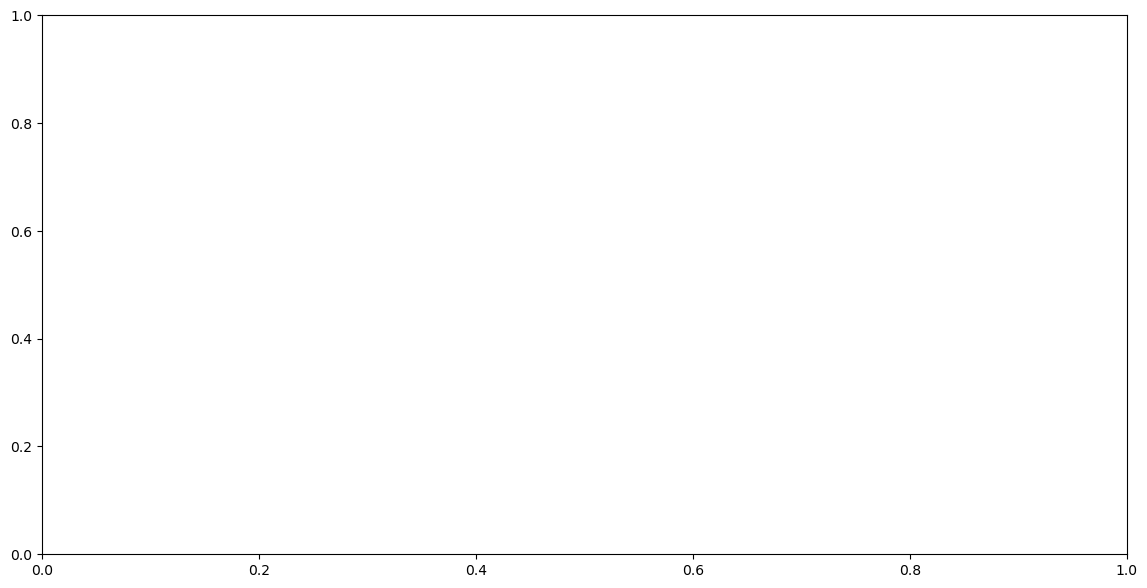

In [223]:
# Call the function to plot all modifications in one plot
plot_baseline_vs_modifications_with_calculated_errors(df_answers)

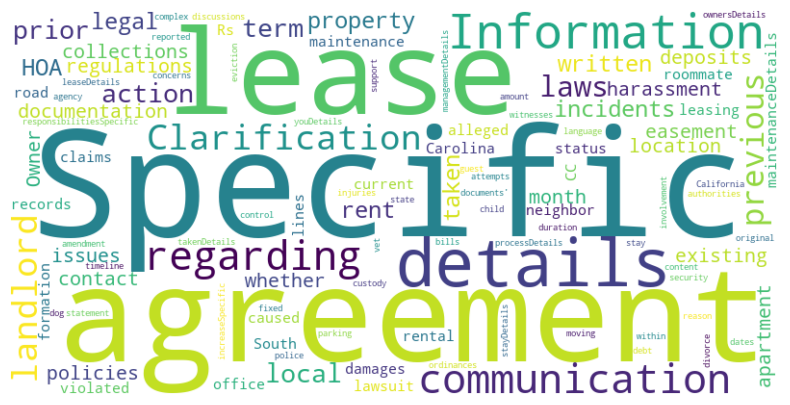

In [615]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Flatten the lists of strings by joining the items in each row
all_words = ''.join([''.join(item) for item in df_answers['var_missing_post']])

# Create a word cloud from the flattened string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [624]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Convert list of strings to a single document
all_sentences = [''.join(item) for item in df_answers['var_missing_post_list']]

# Vectorize the text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(all_sentences)

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(X)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)


Topic 0:
prior agreements regarding information clarification details written communications incidents terms
Topic 1:
specific details information communication clarification agreement rent previous lease existing
Topic 2:
local hoa information actions taken specific details regulations incidents apartment
Topic 3:
lease details regarding landlord agreement specific terms property previous laws
Topic 4:
laws regarding communication specific agreement deposits details collections lease incidents


In [628]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert list of strings to single document
all_sentences = [''.join(item) for item in df_answers['var_missing_post_list']]

# Apply N-gram analysis
vectorizer = CountVectorizer(ngram_range=(3, 4))  # bigrams and trigrams
X = vectorizer.fit_transform(all_sentences)

# Get most common n-grams
ngram_counts = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
sorted_ngram_counts = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)

print(sorted_ngram_counts[:10])  # Top 10 common n-grams


[('details about the', 6), ('the lease agreement', 6), ('information on any', 5), ('with the landlord', 5), ('about the lease', 4), ('communication with the', 4), ('details of the', 4), ('about the lease agreement', 3), ('clarification on the', 3), ('communication with the landlord', 3)]


In [772]:
def gen_lists():
    # base_variables = ['use_rank', 'spec_rank', 'fact_rank', 'leg_rank']
    base_variables = ['var_missing']
    all_lists = []  # To store all the lists
    for base in base_variables:
        var_list = [f'{base}_post']
        for key in var_dict.keys():
            var_list.append(f"{base}_transformed_post_{key}")
        all_lists.append(var_list)  # Add the created list to the main list
    return all_lists  # Return the list of lists

In [1077]:
variables = gen_lists()
variables = variables[0]

In [748]:
from collections import Counter
import pandas as pd

# Variables you want to compare
variables = list1

# Get word counts for each variable
word_counts = {var: Counter("".join(df_answers[var].apply(lambda x: ''.join(x))).split()) for var in variables}

# Convert word counts to DataFrame
df_word_counts = pd.DataFrame(word_counts).fillna(0)

# Display word frequency differences
print(df_word_counts)


TypeError: unhashable type: 'list'

In [750]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to handle joining elements safely
def safe_join(x):
    try:
        if isinstance(x, list):  # If it's a list, join the elements
            return ' '.join(map(str, x))  # Convert non-string elements to strings
        elif isinstance(x, str):  # If it's already a string, return it as-is
            return x
        else:
            return ''  # Handle cases where it's neither a list nor a string
    except Exception as e:
        print(f"Error processing: {x}, Error: {e}")
        return ''  # Return an empty string in case of unexpected errors

# Combine text from each variable into a separate document (list of strings)
documents = [' '.join(df_answers[var].apply(safe_join)) for var in variables]

# Check if any document is empty
for i, doc in enumerate(documents):
    if len(doc.strip()) == 0:
        print(f"Document {i} is empty.")

# Apply TF-IDF to the combined text with no stop words removal
tfidf = TfidfVectorizer(stop_words=None)  # Disable stop word removal
tfidf_matrix = tfidf.fit_transform(documents)

# Convert to DataFrame (transpose the matrix for correct orientation)
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=variables, columns=tfidf.get_feature_names_out())

# Display top terms with highest TF-IDF scores per variable
print(df_tfidf)


Error processing: 0     Details on the specific CC&Rs @@@ Information ...
1     @@@ details of the lease agreement @@@ records...
2     @@@ details on the HOA formation @@@ specific ...
3     @Documentation regarding the easement agreemen...
4     Details about the lawsuit's claims @@@ Specifi...
5     @@@ details of the lease agreement @@@ specifi...
6     Specific details of the lease agreement regard...
7     @$$$ Specific details about the lease agreemen...
8     @ Owner #1 and Owner #2's contact information ...
9     Details of the documents' content @@@ Specific...
10    Details about the apartment complex's policies...
11    Details about the dog's injuries @@@ Specific ...
12    Details on the original lease terms @@@ Specif...
13    Details about any written agreements @@@ Infor...
14    Details about the lease agreement @@@ Informat...
15    Specific location within California @@@ Local ...
16    @@@ details on any existing agreements or disc...
17    @$$$ Specific dates of c

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [708]:
from sklearn.feature_extraction.text import CountVectorizer

# Set the range for n-grams (e.g., bigrams or trigrams)
ngram_vectorizer = CountVectorizer(ngram_range=(2, 3))

# Apply n-gram extraction on the variables
ngram_matrix = ngram_vectorizer.fit_transform(documents)

# Convert to DataFrame
df_ngrams = pd.DataFrame(ngram_matrix.T.toarray(), index=ngram_vectorizer.get_feature_names_out(), columns=variables)

# Display the most common n-grams
print(df_ngrams)


ValueError: Shape of passed values is (2237, 1), indices imply (2237, 8)

In [790]:
from sklearn.feature_extraction.text import CountVectorizer

# Combine the text from both variables
combined_text = df_answers['var_missing_post'] + " " + df_answers['var_missing_transformed_post_jurisdiction']

# Use CountVectorizer to get word frequency
vectorizer = CountVectorizer(stop_words='english')  # Exclude common stop words
X = vectorizer.fit_transform(combined_text)

# Create a DataFrame for the word counts
word_freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Combine all text for each variable into a single string
combined_var1_text = ' '.join(df_answers['var_missing_post'])
combined_var2_text = ' '.join(df_answers['var_missing_transformed_post_jurisdiction'])

# Get word counts for each variable
word_freq_var1 = pd.Series(combined_var1_text.split()).value_counts()
word_freq_var2 = pd.Series(combined_var2_text.split()).value_counts()

# Combine into a DataFrame for easier comparison
word_freq_df = pd.DataFrame({
    'word_freq_var1': word_freq_var1,
    'word_freq_var2': word_freq_var2
}).fillna(0)  # Fill missing values with 0

# # Display the combined word frequencies
# import ace_tools as tools; tools.display_dataframe_to_user(name="Combined Word Frequency Comparison", dataframe=word_freq_df)


In [792]:
word_freq_df

,word_freq_var1,word_freq_var2
#1,1.0,0.0
#1's,0.0,1.0
#2's,1.0,1.0
@,6.0,9.0
@$$$,4.0,3.0
...,...,...
with,9.0,7.0
within,1.0,0.0
witnesses,1.0,1.0
written,3.0,2.0


In [1079]:
# Bigram comparison (can change ngram_range for trigrams, etc.)
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_bigrams = bigram_vectorizer.fit_transform(df_answers['var_missing_post'] + " " + df_answers['var_missing_transformed_post_jurisdiction'])

# Create a DataFrame for bigram frequencies
bigram_freq_df = pd.DataFrame(X_bigrams.toarray(), columns=bigram_vectorizer.get_feature_names_out())

# Display the bigram frequencies
import ace_tools as tools; tools.display_dataframe_to_user(name="Bigram Frequency Comparison", dataframe=bigram_freq_df)


ModuleNotFoundError: No module named 'ace_tools'

# compare to human raters

In [260]:
df['__index_level_0__'] = df['__index_level_0__'].astype(str)
df_raters['__index_level_0__'] = df_raters['__index_level_0__'].astype(str)

# Filter df1 to keep only rows where 'X' values exist in df2['X']
filtered_df = df[df['__index_level_0__'].isin(df_raters['__index_level_0__'])]

# List of columns to add from df2 (besides 'X', which is the common column)
columns_to_add = ['legal_info','legal_prob','usability_rank', 'specificity_rank','factual_rank','legalistic_rank']  # Replace with actual column names from df2

# Create a new DataFrame from df2 with only the columns you want to add and the common 'X' column
df_raters_subset = df_raters[['__index_level_0__'] + columns_to_add].copy()

# Add the suffix '_df2' to the columns from df2 except 'X'
df_raters_subset = df_raters_subset.rename(columns={col: col + '_raters' for col in columns_to_add})

# Merge filtered_df1 with df2_subset on 'X'
filtered_df = filtered_df.merge(df_raters_subset, on='__index_level_0__', how='left')

In [262]:
filtered_df = main_oneshot(filtered_df, ['post'])

In [265]:
df_eval = filtered_df
df_eval.columns = df_eval.columns.str.lower()

df_eval = map_yes_no_to_binary(df_eval, substring="legal_prob")
df_eval = map_yes_no_to_binary(df_eval, substring="legal_info")

C:\Users\mitha\AppData\Local\Temp\ipykernel_15976\559468307.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_map] = df[columns_to_map].replace(mapping)
C:\Users\mitha\AppData\Local\Temp\ipykernel_15976\559468307.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_map] = df[columns_to_map].replace(mapping)


In [267]:
df_eval = df_eval.rename(columns={'usability_rank_raters':'use_rank_raters'})
df_eval = df_eval.rename(columns={'legalistic_rank_raters':'leg_rank_raters'})
df_eval = df_eval.rename(columns={'specificity_rank_raters':'spec_rank_raters'})
df_eval = df_eval.rename(columns={'factual_rank_raters':'fact_rank_raters'})

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import Binarizer

# List of binary and Likert variables
binary_vars = ['legal_prob', 'legal_info']  # Example binary prediction variables
# likert_vars = ['use_rank', 'spec_rank', 'fact_rank', 'leg_rank']  # Example Likert prediction variables
likert_vars = {
    "use_rank": 'Usability',
    "spec_rank": 'Specificity',
    "fact_rank": 'Factual Robustness',
    "leg_rank": 'Legalistic'}


def binarize_if_needed(column):
    # Fill missing values with 0 or a suitable value
    column_filled = column.fillna(0)
    
    if column_filled.nunique() > 2:
        # Assuming a threshold of 0.5 for binarization, adjust as needed
        binarizer = Binarizer(threshold=0.5)
        # Ensure the transformation returns the same length
        return binarizer.fit_transform(column_filled.values.reshape(-1, 1)).ravel()
    return column_filled

def evaluate_metrics_binary(df, var):
    print(f"Evaluating {var}...")
    
    # Binarize columns if needed
    df[f'{var}_raters'] = binarize_if_needed(df[f'{var}_raters'])
    df[f'{var}_post'] = binarize_if_needed(df[f'{var}_post'])
    
    # Ensure lengths match
    assert len(df[f'{var}_raters']) == len(df), "Length mismatch for rater column"
    assert len(df[f'{var}_post']) == len(df), "Length mismatch for post column"

    # Calculate metrics
    accuracy = accuracy_score(df[f'{var}_raters'], df[f'{var}_post'])
    precision = precision_score(df[f'{var}_raters'], df[f'{var}_post'])
    recall = recall_score(df[f'{var}_raters'], df[f'{var}_post'])

    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


In [1716]:
for var in binary_vars:
    evaluate_metrics_binary(df_eval,var)

for var in likert_vars.keys():
    evaluate_metrics_likert(df_eval,var)

Evaluating legal_prob...
Accuracy: 0.98, Precision: 0.98, Recall: 1.0
Evaluating legal_info...
Accuracy: 0.6533333333333333, Precision: 0.3333333333333333, Recall: 0.0196078431372549
Evaluating use_rank...
MSE: 3.37, MAE: 1.54, Correlation: 0.24, Exact Match Rate: 0.15
Evaluating spec_rank...
MSE: 4.13, MAE: 1.68, Correlation: 0.41, Exact Match Rate: 0.15
Evaluating fact_rank...
MSE: 2.42, MAE: 1.28, Correlation: 0.38, Exact Match Rate: 0.17
Evaluating leg_rank...
MSE: 1.88, MAE: 1.07, Correlation: 0.33, Exact Match Rate: 0.21


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualize confusion matrix for binary variables
def plot_confusion_matrix(df,var):
    cm = confusion_matrix(df[f'{var}_raters'], df[f'{var}_post'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {var}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Visualize precision, recall, F1 for binary variables
def plot_binary_metrics(df,var):
    accuracy = accuracy_score(df[f'{var}_raters'], df[f'{var}_post'])
    precision = precision_score(df[f'{var}_raters'], df[f'{var}_post'])
    recall = recall_score(df[f'{var}_raters'], df[f'{var}_post'])
    f1 = f1_score(df[f'{var}_raters'], df[f'{var}_post'])
    metrics = pd.DataFrame({'Metric': ['Accuracy','Precision', 'Recall', 'F1-Score'], 'Score': [accuracy, precision, recall, f1]})
    
    sns.barplot(x='Metric', y='Score', data=metrics)
    plt.title(f'Metrics for {var}')
    plt.ylim(0, 1)
    plt.show()

# Visualize scatter plot for Likert variables
def plot_likert_scatter(df,var):
    plt.scatter(df[f'{var}_raters'], df[f'{var}_post'], alpha=0.5)
    plt.plot([1, 7], [1, 7], color='red', linestyle='--')  # 1-7 Likert scale diagonal line
    plt.xlabel(f'{likert_vars[var]} (Human)')
    plt.ylabel(f'{likert_vars[var]} (Model)')
    plt.title(f'Scatter of Predicted and Human Rating: {likert_vars[var]}')
    plt.tight_layout()
    plt.savefig(project_path("figures", f"Scatter Ranking of predicted vs human rating_{var}.png"), bbox_inches='tight')
    plt.close()

# Visualize distribution of predictions and benchmark for Likert variables
def plot_likert_distribution(df,var):
    sns.histplot(df[f'{var}_raters'], color='blue', label='True', kde=True, stat='density')
    sns.histplot(df[f'{var}_post'], color='orange', label='Predicted', kde=True, stat='density')
    plt.title(f'Distribution of Predicted and Human Rating: {likert_vars[var]}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(project_path("figures", f"Distribution Ranking of predicted vs human rating_{var}.png"), bbox_inches='tight')
    plt.close()


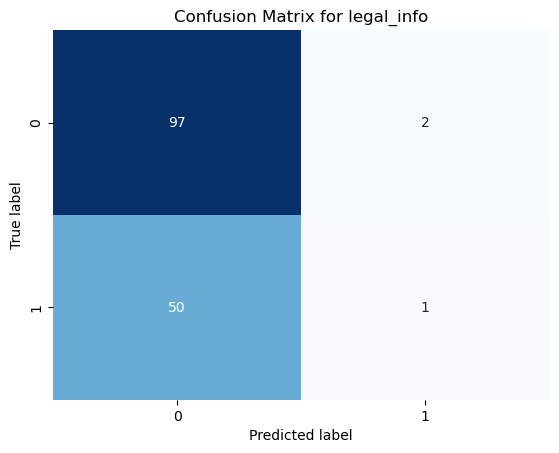

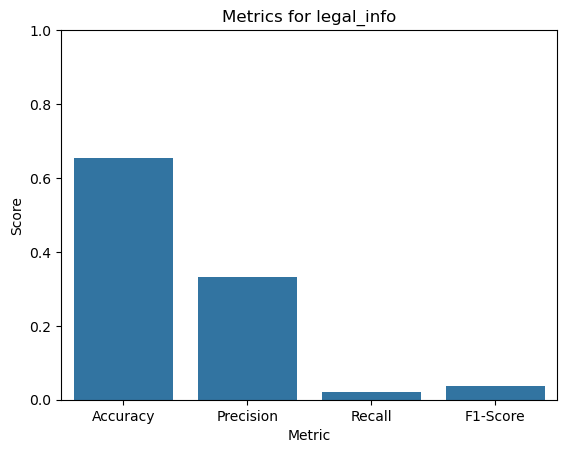

In [1760]:
# For binary variable
plot_confusion_matrix(df_eval,binary_vars[1])  # Replace 'var1' with your binary variable name
plot_binary_metrics(df_eval,binary_vars[1])

In [78]:
for var in likert_vars.keys():
    plot_likert_scatter(df_eval,var)  
    plot_likert_distribution(df_eval,var)  

NameError: name 'df_eval' is not defined

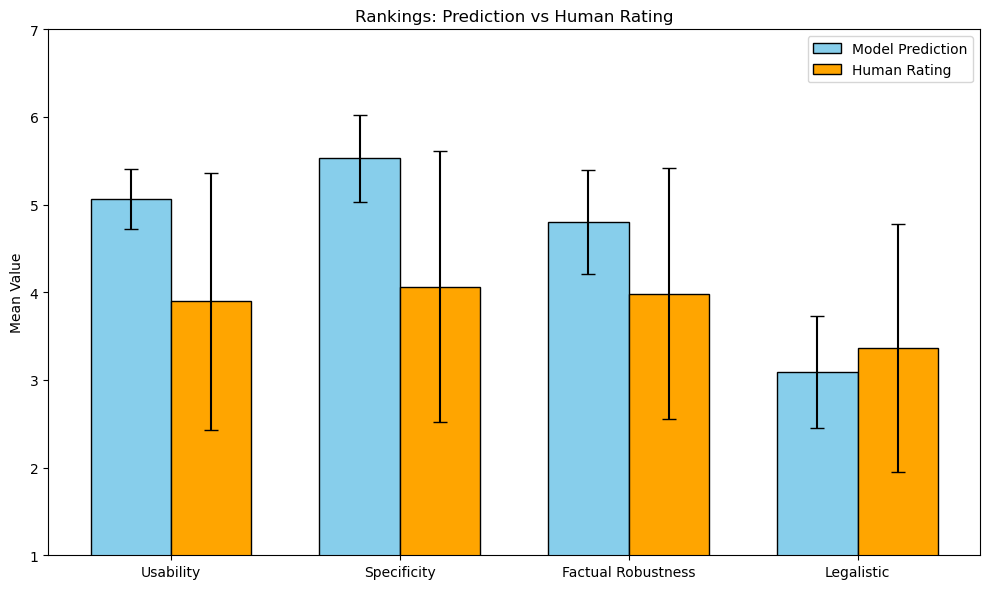

In [1722]:
def generate_variable_lists_eval(custom_string):
    """
    Generates two lists of variables, with 'contract' replaced by a custom string in the second list (variables_B).
    
    Args:
    - custom_string: The string to plug into variables_B in place of 'contract'.
    
    Returns:
    - variables_A: List of variables for version A.
    - variables_B: List of variables for version B, with the custom string replacing 'contract'.
    """
    # Define the base for variables_A and variables_B without 'contract'
    base_variables = ['use_rank', 'spec_rank', 'fact_rank', 'leg_rank']
    
    # Generate variables_A (static version names)
    variables_A = [f"{base}_post" for base in base_variables]
    
    # Generate variables_B with the custom string replacing 'contract'
    variables_B = [f"{base}_{custom_string}" for base in base_variables]
    
    return variables_A, variables_B


def plot_paired_means_with_variation_eval(df, modified_var, variation='std'):
    """
    Creates grouped bar plots showing the mean values and variation for paired variables
    (e.g., var1_A, var1_B, var2_A, var2_B) in two versions (A and B).
    
    Args:
    - df: The DataFrame containing the data.
    - variables_A: List of variable names for version A (e.g., ['var1_A', 'var2_A']).
    - variables_B: List of variable names for version B (e.g., ['var1_B', 'var2_B']).
    - labels: List of labels for the variables (e.g., ['Variable 1', 'Variable 2']).
    - variation: Type of variation to display ('std' for standard deviation, 'sem' for standard error).
    
    Returns:
    - None: Displays the plot.
    """
    # Labels for the variables
    labels = ['Usability', 'Specificity', 'Factual Robustness', 'Legalistic']

    variables_A, variables_B = generate_variable_lists_eval(modified_var)

    # Calculate the mean and variation for each version
    means_A = df[variables_A].mean()
    means_B = df[variables_B].mean()
    
    if variation == 'std':
        errors_A = df[variables_A].std()  # Standard deviation for version A
        errors_B = df[variables_B].std()  # Standard deviation for version B
    elif variation == 'sem':
        errors_A = df[variables_A].sem()  # Standard error for version A
        errors_B = df[variables_B].sem()  # Standard error for version B
    else:
        raise ValueError("Invalid variation type. Choose 'std' or 'sem'.")
    
    # Set the number of variables
    num_vars = len(variables_A)
    
    # Set positions for the bars on the x-axis
    x_positions = np.arange(num_vars)
    width = 0.35  # Width of the bars
    
    # Plot the bars with error bars
    plt.figure(figsize=(10, 6))
    plt.bar(x_positions - width/2, means_A, width, yerr=errors_A, capsize=5, label='Model Prediction', color='skyblue', edgecolor='black')
    plt.bar(x_positions + width/2, means_B, width, yerr=errors_B, capsize=5, label=f'Human Rating', color='orange', edgecolor='black')
    
    # Set the labels and titles
    plt.xticks(x_positions, labels, rotation=0)
    plt.ylabel('Mean Value')
    plt.title(f'Rankings: Prediction vs Human Rating')
    
    # Add legend
    plt.legend()
    
    # Set y-axis limit to be 1-7 (if applicable, adjust if needed)
    plt.ylim(1, 7)
    
    # Display the plot
    plt.tight_layout()

    plt.savefig(project_path("figures", f"Mean Ranking of predicted vs human rating.png"), bbox_inches='tight')

    # plt.show()


plot_paired_means_with_variation_eval(df_eval, 'raters', variation='std')

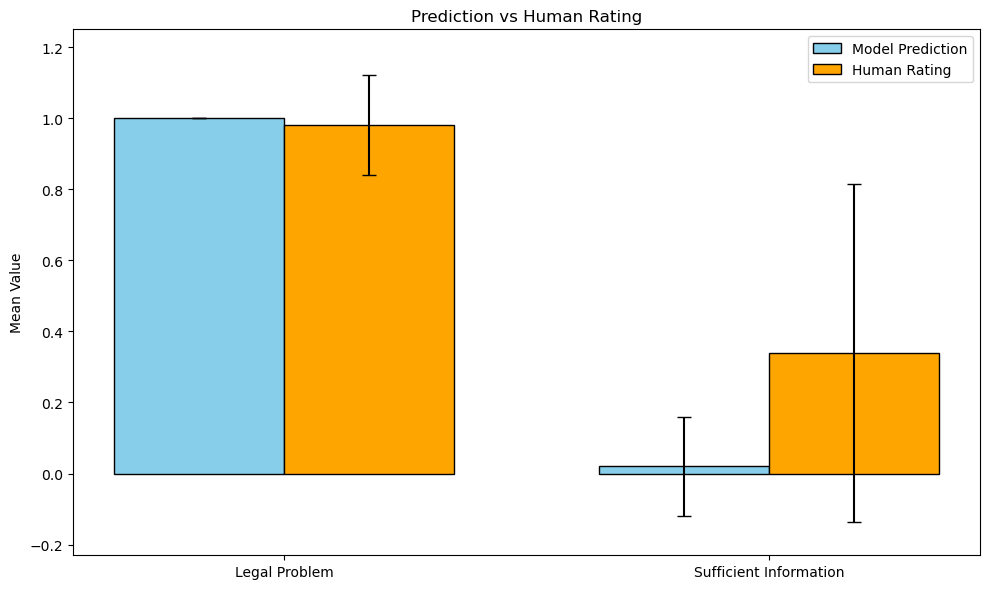

In [1724]:
def plot_means_eval(df, variation):
    labels = ['Legal Problem', 'Sufficient Information']

    variables_A, variables_B = ['legal_prob_post', 'legal_info_post'], ['legal_prob_raters', 'legal_info_raters']

    # Calculate the mean and variation for each version
    means_A = df[variables_A].mean()
    means_B = df[variables_B].mean()

    if variation == 'std':
        errors_A = df[variables_A].std()  # Standard deviation for version A
        errors_B = df[variables_B].std()  # Standard deviation for version B
    elif variation == 'sem':
        errors_A = df[variables_A].sem()  # Standard error for version A
        errors_B = df[variables_B].sem()  # Standard error for version B
    else:
        raise ValueError("Invalid variation type. Choose 'std' or 'sem'.")

    # Set the number of variables
    num_vars = len(variables_A)

    # Set positions for the bars on the x-axis
    x_positions = np.arange(num_vars)
    width = 0.35  # Width of the bars

    # Plot the bars with error bars
    plt.figure(figsize=(10, 6))
    plt.bar(x_positions - width/2, means_A, width, yerr=errors_A, capsize=5, label='Model Prediction', color='skyblue', edgecolor='black')
    plt.bar(x_positions + width/2, means_B, width, yerr=errors_B, capsize=5, label=f'Human Rating', color='orange', edgecolor='black')

    # Set the labels and titles
    plt.xticks(x_positions, labels, rotation=0)
    plt.ylabel('Mean Value')
    plt.title(f'Prediction vs Human Rating')

    # Add legend
    plt.legend(loc='upper right')

    # Dynamically adjust y-axis limits based on min and max mean values
    min_val = min(means_A.min(), means_B.min())
    max_val = max(means_A.max(), means_B.max())
    
    # Adjust y-axis limits slightly below and above the actual values
    plt.ylim(min_val-0.25, max_val + 0.25)

    # Display the plot
    plt.tight_layout()
    plt.savefig(project_path("figures", f"Mean of predicted vs human rating binary vars.png"), bbox_inches='tight')

# Example usage (assuming df_eval is properly defined and populated)
plot_means_eval(df_eval, variation='std')


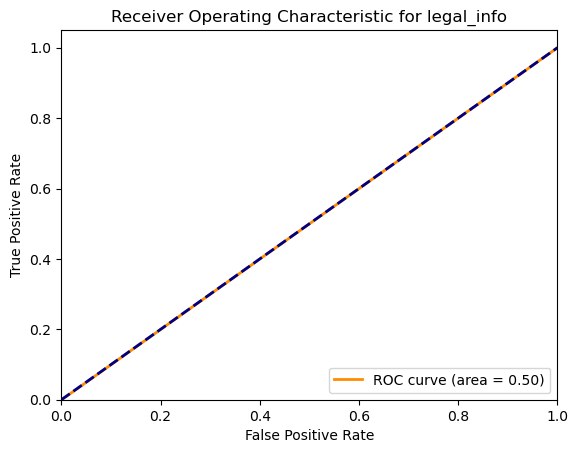

In [1752]:
from sklearn.metrics import roc_curve, auc
df_eval[['legal_info_raters','legal_info_post']] = df_eval[['legal_info_raters','legal_info_post']].astype(int)

# Plot ROC curve and compute AUC
def plot_roc_auc(df,var):
    fpr, tpr, thresholds = roc_curve(df[f'{var}_raters'], df[f'{var}_post'])  # Predicted probabilities
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {var}')
    plt.legend(loc="lower right")
    plt.show()

# Example usage
plot_roc_auc(df_eval,'legal_info')  # Replace 'var1' with your binary variable


In [277]:
df_missingvars = df_eval
df_missingvars['var_missing_raters'] = df_raters['var_missing_rater2']

In [279]:
import ast
import itertools
from transformers import pipeline
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os

# Create a big list from a DataFrame column containing lists or strings
def create_list(df, var):
    missing_vars_list = []
    
    for item in df[var]:
        # Try to parse strings as lists
        if isinstance(item, str):
            try:
                item = ast.literal_eval(item)
            except (ValueError, SyntaxError):
                pass  # Keep as a string if it's not a list
        
        # Check the type using type()
        if isinstance(item, list):
            missing_vars_list.extend(item)
        else:
            missing_vars_list.append(item)
    
    # Flatten the list of lists into one big list
    missing_vars_list = list(itertools.chain.from_iterable(
        [item if isinstance(item, list) else [item] for item in missing_vars_list]))
    
    # Split any items containing '@' into separate items
    final_list = []
    for item in missing_vars_list:
        if isinstance(item, str):
            split_items = [sub_item.strip() for sub_item in item.split('@') if sub_item]
            final_list.extend(split_items)
    return final_list

# Classify categories using Hugging Face zero-shot classification
def classify_categories(final_list):
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    candidate_labels = list(var_dict.keys())
    
    classified_items = {}
    for item in final_list:
        result = classifier(item, candidate_labels)
        top_labels = result['labels'][:2]  # Get top 2 labels
        classified_items[item] = top_labels
    return classified_items

# Plot categories side-by-side for two variables with error bars
def plot_categories_side_by_side(df, var_name1, var_name2):
    var1 = f'var_missing_{var_name1}'
    var2 = f'var_missing_{var_name2}'

    # Get lists and classify categories for both variables
    final_list1 = create_list(df, var1)
    classified_items1 = classify_categories(final_list1)
    
    final_list2 = create_list(df, var2)
    classified_items2 = classify_categories(final_list2)
    
    # Count category frequencies for both variables
    category_counts1 = Counter()
    for categories in classified_items1.values():
        category_counts1.update(categories)
    
    category_counts2 = Counter()
    for categories in classified_items2.values():
        category_counts2.update(categories)
    
    # Ensure both sets of categories are aligned
    all_categories = list(set(list(category_counts1.keys()) + list(category_counts2.keys())))
    counts1 = [category_counts1.get(cat, 0) for cat in all_categories]
    counts2 = [category_counts2.get(cat, 0) for cat in all_categories]
    
    # Calculate error bars (standard error for Poisson distribution: sqrt(counts))
    errors1 = [np.sqrt(count) for count in counts1]
    errors2 = [np.sqrt(count) for count in counts2]
    
    # Plot side-by-side bar chart
    bar_width = 0.35
    index = np.arange(len(all_categories))

    plt.figure(figsize=(12, 7))
    
    # Bars for var1 (Human Rater) with error bars
    plt.bar(index, counts1, bar_width, label='Human Rater', color='orange', yerr=errors1, capsize=5)
    
    # Bars for var2 (Model Output) with error bars
    plt.bar(index + bar_width, counts2, bar_width, label='Model Output', color='lightblue', yerr=errors2, capsize=5)
    
    # Labels and title
    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.title('Frequency of Classified Categories: Human Review vs Model')
    plt.xticks(index + bar_width / 2, all_categories, rotation=45, ha='right')
    plt.legend()
    
    plt.tight_layout()
    
    # Ensure directory exists and save the plot
    save_dir = os.path.join("G:", os.sep, "My Drive", "Work", "Working Papers", "LLM and Legal Advice", "figures")
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, "Frequency_of_Classified_Categories_Human_vs_Model_With_Error_Bars.png"), bbox_inches='tight')
    plt.show()

C:\Users\mitha\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


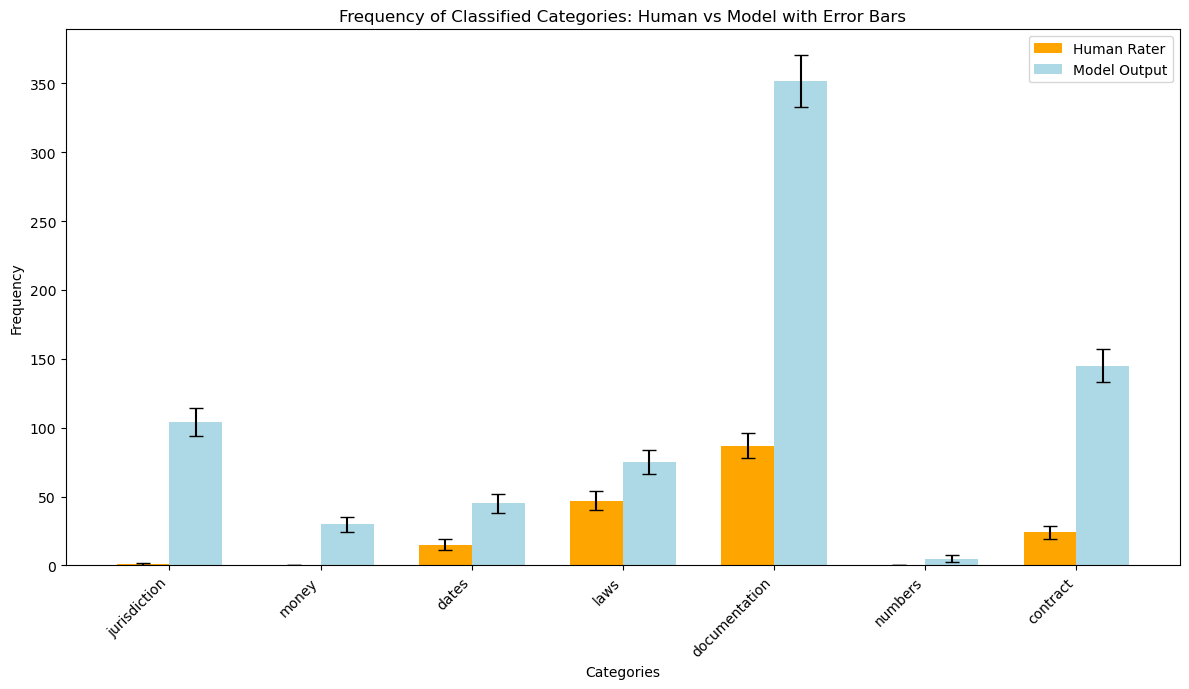

In [281]:
plot_categories_side_by_side(df_missingvars,'raters','post')

## Compare Few Shot and One Shot


In [137]:
df_raters['__index_level_0__'] = df_raters['__index_level_0__'].astype(str)

# List of columns to add from df2 (besides 'X', which is the common column)
columns_to_add = ['legal_info','legal_prob','usability_rank', 'specificity_rank','factual_rank','legalistic_rank']  # Replace with actual column names from df2

# Add the suffix '_df2' to the columns from df2 except 'X'
df_raters = df_raters.rename(columns={col: col + '_raters' for col in columns_to_add})

df_raters = df_raters.rename(columns={'usability_rank_raters':'use_rank_raters'})
df_raters = df_raters.rename(columns={'legalistic_rank_raters':'leg_rank_raters'})
df_raters = df_raters.rename(columns={'specificity_rank_raters':'spec_rank_raters'})
df_raters = df_raters.rename(columns={'factual_rank_raters':'fact_rank_raters'})

df_raters = df_raters[['__index_level_0__','use_rank_raters', 'spec_rank_raters', 'leg_rank_raters',
       'fact_rank_raters', 'legal_prob_raters', 'legal_info_raters']]

df_merged_shots['__index_level_0__'] = df_merged_shots['__index_level_0__'].astype(str)

df_merged_shots = pd.merge(df_merged_shots, df_raters, on='__index_level_0__')

In [193]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import spacy.cli


def plot_paired_means_fewshot(df, variation='std'):
    """
    Creates grouped bar plots showing the mean values and variation for paired variables
    (e.g., var1_A, var1_B, var2_A, var2_B) in two versions (A and B).
    
    Args:
    - df: The DataFrame containing the data.
    - variables_A: List of variable names for version A (e.g., ['var1_A', 'var2_A']).
    - variables_B: List of variable names for version B (e.g., ['var1_B', 'var2_B']).
    - labels: List of labels for the variables (e.g., ['Variable 1', 'Variable 2']).
    - variation: Type of variation to display ('std' for standard deviation, 'sem' for standard error).
    
    Returns:
    - None: Displays the plot.
    """
    base_variables = ['use_rank', 'spec_rank', 'fact_rank', 'leg_rank']
    
    # Generate variables_A
    variables_A = [f"{base}_post_oneshot" for base in base_variables]
    
    # Generate variables_B
    variables_B = [f"{base}_post_fewshot" for base in base_variables]

    variables_C = [f"{base}_raters" for base in base_variables]

    # Labels for the variables
    labels = ['Usability', 'Specificity', 'Factual Robustness', 'Legalistic']

    # Calculate the mean and variation for each version
    means_A = df[variables_A].mean()
    means_B = df[variables_B].mean()
    means_C = df[variables_C].mean()

    if variation == 'std':
        errors_A = df[variables_A].std()  # Standard deviation for version A
        errors_B = df[variables_B].std()  # Standard deviation for version B
        errors_C = df[variables_C].std()  # Standard deviation for version C

    elif variation == 'sem':
        errors_A = df[variables_A].sem()  # Standard error for version A
        errors_B = df[variables_B].sem()  # Standard error for version B
        errors_C = df[variables_C].sem()  # Standard error for version C

    else:
        raise ValueError("Invalid variation type. Choose 'std' or 'sem'.")
    
    # Set the number of variables
    num_vars = len(variables_A)
    
    # Set positions for the bars on the x-axis
    x_positions = np.arange(num_vars)
    width = 0.25  # Width of the bars
    
    # Plot the bars with error bars
    plt.figure(figsize=(10, 6))
    
    # Adjust x_positions for each group of bars
    plt.bar(x_positions - width, means_A, width, yerr=errors_A, capsize=5, label='One Shot', color='skyblue', edgecolor='black')
    plt.bar(x_positions, means_B, width, yerr=errors_B, capsize=5, label='Few Shot', color='lightgreen', edgecolor='black')
    plt.bar(x_positions + width, means_C, width, yerr=errors_C, capsize=5, label='Human Review', color='orange', edgecolor='black')
    
    # Set the labels and titles
    plt.xticks(x_positions, labels, rotation=0)
    plt.ylabel('Mean Value')
    plt.title('Rankings: One Shot, Few Shot, and Human Review')
    
    # Add legend
    plt.legend()
    
    # Set y-axis limit to be 1-7 (if applicable, adjust if needed)
    plt.ylim(1, 7)
    
    # Display the plot
    plt.tight_layout()

    plt.savefig(project_path("figures", "Mean Rankings_One Shot, Few Shot, and Human Review.png"), bbox_inches='tight')
    plt.clf()


def plot_means_fewshot(df, variation):
    labels = ['Legal Problem', 'Sufficient Information']

    # Variables for One Shot, Few Shot, and Human Review
    variables_A = ['legal_prob_post_oneshot', 'legal_info_post_oneshot']  # One Shot Prediction
    variables_B = ['legal_prob_post_fewshot', 'legal_info_post_fewshot']  # Few Shot Prediction
    variables_C = ['legal_prob_raters', 'legal_info_raters']  # Human Review

    # Calculate the mean and variation for each version
    means_A = df[variables_A].mean()  # Mean for One Shot (Model Prediction)
    means_B = df[variables_B].mean()  # Mean for Few Shot (Model Prediction)
    means_C = df[variables_C].mean()  # Mean for Human Review

    if variation == 'std':
        errors_A = df[variables_A].std()  # Standard deviation for One Shot
        errors_B = df[variables_B].std()  # Standard deviation for Few Shot
        errors_C = df[variables_C].std()  # Standard deviation for Human Review
    elif variation == 'sem':
        errors_A = df[variables_A].sem()  # Standard error for One Shot
        errors_B = df[variables_B].sem()  # Standard error for Few Shot
        errors_C = df[variables_C].sem()  # Standard error for Human Review
    else:
        raise ValueError("Invalid variation type. Choose 'std' or 'sem'.")

    # Set the number of variables
    num_vars = len(variables_A)

    # Set positions for the bars on the x-axis
    x_positions = np.arange(num_vars)
    width = 0.2  # Width of the bars

    # Plot the bars with error bars
    plt.figure(figsize=(10, 6))
    
    # Plot One Shot, Few Shot, and Human Review side by side
    plt.bar(x_positions - width, means_A, width, yerr=errors_A, capsize=5, label='One Shot', color='skyblue', edgecolor='black')
    plt.bar(x_positions, means_B, width, yerr=errors_B, capsize=5, label='Few Shot', color='lightgreen', edgecolor='black')
    plt.bar(x_positions + width, means_C, width, yerr=errors_C, capsize=5, label='Human Review', color='orange', edgecolor='black')

    # Set the labels and titles
    plt.xticks(x_positions, labels, rotation=0)
    plt.ylabel('Mean Value')
    plt.title('One Shot vs Few Shot vs Human Review')

    # Add legend
    plt.legend(loc='upper right')

    # Dynamically adjust y-axis limits based on min and max mean values
    min_val = min(means_A.min(), means_B.min(), means_C.min())
    max_val = max(means_A.max(), means_B.max(), means_C.max())
    
    # Adjust y-axis limits slightly below and above the actual values
    plt.ylim(min_val - 0.25, max_val + 0.25)

    # Display the plot
    plt.tight_layout()
    plt.savefig(project_path("figures", "mean binary vars_ One Shot, Few Shot, and Human Review.png"), bbox_inches='tight')
    plt.clf()


# Download the model if not already installed
spacy.cli.download("en_core_web_md")

# Load a spaCy model with vectors (you can use 'en_core_web_md' or 'en_core_web_trf')
nlp = spacy.load("en_core_web_md")

# Function to convert a single text to its spaCy vector representation
def get_spacy_embedding(text):
    return nlp(text).vector

def generate_plot_cosine_fewshot(df):
    df['embedding_oneshot'] = df['best_response_post_oneshot'].apply(get_spacy_embedding)
    df['embedding_fewshot'] = df['best_response_post_fewshot'].apply(get_spacy_embedding)

    # Calculate cosine similarity for each pair of embeddings
    df['cosine_similarity_answer'] = df.apply(lambda row: cosine_similarity([row['embedding_oneshot']], [row['embedding_fewshot']])[0][0], axis=1)
   
    overall_mean = df['cosine_similarity_answer'].mean()
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df['cosine_similarity_answer'], kde=True, bins=50)
    plt.axvline(overall_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {overall_mean:.2f}')
    plt.title('Distribution of cosine similarity between model answers: One Shot vs Few Shot Prompting')
    plt.xlabel('Mean Value')
    plt.ylabel('Density')
    plt.savefig(project_path("figures", f"Distribution of cosine similarity between model answers_One Shot vs Few Shot Prompting.png"), bbox_inches='tight')
    plt.clf()

    # plt.show()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [194]:
plot_paired_means_fewshot(df_merged_shots, variation='std')

plot_means_fewshot(df_merged_shots, variation='std')

generate_plot_cosine_fewshot(df_merged_shots)

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>